# Instituto Tecnológico y de Estudios Superiores de Monterrey
## Maestría en Inteligencia Artificial Aplicada
### Proyecto Integrador (Gpo 10) - TC5035.10

### **Proyecto: Diseño Acelerado de Fármacos Agonistas de la Hormona GLP-1**

### Avance 5: Modelo final

#### **Docentes:**
- Dra. Grettel Barceló Alonso - Profesor Titular
- Dr. Luis Eduardo Falcón Morales - Profesor Titular
- Dra. Eduviges Ludivina Facundo Flores  – Profesor Tutor

### **Asesores**
- Dr. Juan Arturo Nolazco Flores
- Dr. Carlos Alberto Brizuela Rodríguez

#### **Miembros del equipo:**
- Cesar Ivan Herrera Martinez A01796392  
- Juan Antonio Cruz Acosta A01795375 
- Julio Baltazar Colín A01794476 

# Modelos Finales
Generación de Nuevas secuencias Peptídicas Agonistas de GLP-1 mediante Modelos de Lenguaje y Evaluación In Silico de su Actividad Biológica

## Introducción
En esta quinta etapa se presenta el desarrollo e integración del modelo final para la generación y evaluación de nuevas secuencias peptídicas con potencial actividad agonista del receptor GLP-1. Esta fase consolida los avances obtenidos en etapas anteriores, extendiendo el uso de la inteligencia artificial desde la predicción de actividad biológica hasta la generación de novo de secuencias candidatas mediante modelos de lenguaje profundo y su posterior evaluación con modelos predictivos de aprendizaje automático.
El trabajo comenzó con una exploración computacional de modelos biomoleculares basados en arquitecturas Transformer, como ProtXLNet y PeptideBERT, con el objetivo de capturar patrones estructurales y funcionales de los péptidos. Estas etapas iniciales también permitieron establecer las propiedades críticas para la viabilidad farmacológica —como hemólisis, solubilidad y no adherencia— que servirían como criterios de filtrado para las secuencias generadas.
Posteriormente, se seleccionó ProtGPT2 como núcleo del modelo generativo. Este modelo, una adaptación del lenguaje GPT-2 entrenado específicamente con secuencias proteicas, fue elegido por su capacidad superior para generar secuencias completas, coherentes y biológicamente plausibles. En comparación con ProtXLNet, ProtGPT2 mostró una mayor diversidad y variabilidad estructural, superando la naturaleza más conservadora de los modelos previos.
Para la evaluación de la coherencia y capacidad predictiva del modelo generativo, se evaluaron las secuencias generadas por los modelos en cuando a su potencia, solubilidad y hemolisis. Esto permitió cuantificar la capacidad del modelo para predecir la disposición de los aminoácidos y, con ello, estimar la calidad de las secuencias generadas.
Las secuencias obtenidas fueron analizadas mediante un modelo predictivo de clasificación basado en un ensemble de Random Forest, desarrollado en fases anteriores del proyecto. Este modelo, entrenado con datos experimentales de péptidos agonistas y no agonistas de GLP-1, fue empleado como herramienta principal para estimar in silico la posible actividad biológica de las secuencias propuestas por ProtGPT2.
Finalmente, se aplicó este mismo modelo predictivo a un conjunto externo de secuencias obtenido de las bases de datos de Google AlphaFold, con el propósito de identificar nuevos candidatos con potencial actividad agonista del receptor GLP-1. Este análisis complementario amplió el espectro de secuencias disponibles y fortaleció la estrategia de diseño racional de péptidos terapéuticos.


## Evaluacion de las seccuencias cononocidas de Alpha Fold con el modelo predictivo

A fin de detectar posibles nuevas secuencias agonistas de GLP-1, se evaluó un conjunto de secuencias obtenidas de la base de datos de Google Alpha Fold utilizando el modelo predictivo basado en Random Forest desarrollado previamente. Este conjunto de secuencias contenía una amplia variedad de péptidos, algunos de los cuales podrían tener actividad biológica relevante. El modelo predictivo se aplicó a cada una de las secuencias del conjunto, y se analizaron los resultados para identificar aquellas secuencias que fueron clasificadas como agonistas de GLP-1.

## Carga de los datos base para uso de los modelos

Para esta evaluación, se emplearan todos los datos procesados con anterioridad, incluyendo el conjunto de 125 péptidos con actividad EC50 conocida, el conjunto de entrenamiento de 224 péptidos de alta diversidad y el conjunto de secuencias similares al GLP-1 obtenidas de las bases de datos de Alpha Fold y UniProt. Con estos datos se procederá a evaluar el desempeño del modelo predictivo y a identificar posibles nuevas secuencias agonistas de GLP-1. en los datos ya conocidos de alfa fold. Posteriormente se procederá a la generación de nuevas secuencias mediante ProtGPT2 y su evaluación con el modelo predictivo.

In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
from pathlib import Path
# iFeature cambia la configuración de matplotlib, por lo que se debe volver a activar
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# ruta del directorio del notebook actual
notebook_dir = Path.cwd()
directorio_base = Path.cwd().parent
sys.path.append(str(directorio_base))

from src.plotting import plot_pca_3d, clasificar_y_graficar_cuantiles


In [2]:
# Establecer la ruta los archivos de datos

directorio_datos = Path(directorio_base / "data")
directorio_modelos = Path(directorio_base / "models")
directorio_modelos_automl= Path(directorio_modelos / "pycaret")
raw_data_dir = directorio_datos / "raw"
processed_data_dir = directorio_datos / "processed"

#ruta a los modelos automl
ruta_mejor_modelo_final = directorio_modelos_automl / "modelos_GLP1_no_pca" /"mejor_modelo_final"
# Ruta modelos generativos
ruta_modelo_protxlnet = directorio_modelos / "prot_xlnet_finetuned"

# Datos con actividad conocida
ruta_125_ec50 = processed_data_dir / "descriptores_125.csv"

# Datos con actividad predicha
ruta_predicciones_glp1 = processed_data_dir / "predicciones_glp1.csv"

# Datos sin actividad conocida
ruta_peptidos_eval = processed_data_dir / "descriptores_cdhit.csv"

#Datos de identificacion de secuencias con especie
ruta_glucagon_like_peptides = processed_data_dir / "glucagon_like_peptides.csv"

# directorio para nuevas secuencias 
directorio_nuevas_secuencias = Path(processed_data_dir/"Actividad_5"/"secuencias_nuevas")
os.makedirs(directorio_nuevas_secuencias, exist_ok=True)

# directorio modelos peptide Bert
directorio_modelos_peptidebert = directorio_modelos / "peptideBert"


# directorio temporal
directorio_temporal = Path(directorio_base / "temp")
os.makedirs(directorio_temporal, exist_ok=True)


### Acondicionamiento de los datos de alpha fold para su uso en los modelos
Los datos de secuencias similares al GLP-1 obtenidos de las bases de datos de Alpha Fold y UniProt se cargaron y acondicionaron para su uso en los modelos predictivos. Este proceso incluyó la limpieza de los datos, la eliminación de secuencias duplicadas y la normalización de las secuencias para asegurar su compatibilidad con el modelo. Una vez acondicionados, estos datos se integraron con los conjuntos de datos existentes para su evaluación y análisis posterior. En este caso se eliminaran las columnas que no son necesarias para la evaluación del modelo predictivo, como las columnas relacionadas con la estructura de la consulta en la base de datos, y se mantendrán únicamente las columnas relevantes para la secuencia y su identificación.


In [3]:
# Cargar datos procesados con anterioridad
df_125_conocidos = pd.read_csv(ruta_125_ec50)
#df_125_conocidos.set_index('ID', inplace=True)
df_125_conocidos.columns = df_125_conocidos.columns.str.replace('.', '_', regex=False)
df_125_conocidos['-1pEC50'] = -np.log10(df_125_conocidos["EC50_T2"] * 1e-12)

df_glp1 = pd.read_csv(ruta_peptidos_eval)
#df_glp1.set_index('ID', inplace=True)
df_glp1.columns = df_glp1.columns.str.replace('.', '_', regex=False)

df_glucagon_like_peptides = pd.read_csv(ruta_glucagon_like_peptides)
df_glucagon_like_peptides['ID'] = df_glucagon_like_peptides['ID'].str.replace("|", "-")
df_glucagon_like_peptides = df_glucagon_like_peptides[ ["ID", "Description", "GLP-1_Activo", "Species", "organismCommonNames"]].rename(columns={'GLP-1_Activo': 'sequence'})

In [4]:
# visualizar los con 125 péptidos con actividad ec 50 conocida
df_125_conocidos.info()
display(df_125_conocidos.head() )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Columns: 1295 entries, ID to -1pEC50
dtypes: float64(1293), object(2)
memory usage: 1.2+ MB


ID     AAC_A  AAC_C     AAC_D     AAC_E     AAC_F     AAC_G  \
0  seq_pep1  0.033333    0.0  0.100000  0.100000  0.066667  0.066667   
1  seq_pep2  0.033333    0.0  0.100000  0.100000  0.066667  0.066667   
2  seq_pep3  0.034483    0.0  0.103448  0.068966  0.068966  0.034483   
3  seq_pep4  0.055556    0.0  0.083333  0.027778  0.055556  0.166667   
4  seq_pep5  0.066667    0.0  0.100000  0.066667  0.066667  0.066667   

      AAC_H  AAC_I     AAC_K  ...  NMBroto_BEGF750103_lag1  \
0  0.033333    0.0  0.033333  ...                -0.027980   
1  0.033333    0.0  0.033333  ...                 0.000910   
2  0.034483    0.0  0.034483  ...                -0.004817   
3  0.027778    0.0  0.027778  ...                 0.225090   
4  0.033333    0.0  0.033333  ...                 0.088858   

   NMBroto_BEGF750103_lag2  NMBroto_BEGF750103_lag3  NMBroto_BHAR880101_lag1  \
0                -0.182783                 0.054222                 0.190428   
1                -0.316149                 0.170202                 0.157133   
2                -0.250582                 0.181550                 0.098041   
3                -0.097965                 0.052838                 0.377701   
4                -0.190213                 0.020097                 0.069381   

   NMBroto_BHAR880101_lag2  NMBroto_BHAR880101_lag3  \
0                -0.142437                 0.090372   
1                -0.144228                 0.115217   
2                -0.203722                 0.127012   
3                 0.150231                 0.286987   
4                -0.184796                 0.222087   

                               sequence  EC50_T2  EC50_LOG_T2    -1pEC50  
0        HSQGTFTSDYSKYLDSRRAQDFVQWLEEGE   563.00        -9.25   9.249492  
1        HSQGTFTSDYSKYLDSRRAEDFVQWLENGE   552.00        -9.26   9.258061  
2         HSQGTFTSDYSKYLDSRRAEDFVQWLENT   252.00        -9.60   9.598599  
3  HSQGTFTSDYSKYLDSRRAEDFVQWLVAGGSGSGSG     6.03       -11.22  11.219683  
4        HSQGTFTSDYSKYLDSRRAQDFVQWLEAEG   238.00        -9.62   9.623423  

[5 rows x 1295 columns]

In [5]:
# visualizar los datos entrenamiento, 224 péptidos de alta diversidad

df_glp1.info()
display(df_glp1.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Columns: 1292 entries, ID to sequence
dtypes: float64(1290), object(2)
memory usage: 2.2+ MB


ID     AAC_A  AAC_C     AAC_D     AAC_E     AAC_F     AAC_G  \
0  AF-A0A060VXS0-F1  0.100000    0.0  0.066667  0.066667  0.033333  0.066667   
1  AF-A0A060VY52-F1  0.100000    0.0  0.066667  0.066667  0.033333  0.066667   
2  AF-A0A060WDT4-F1  0.100000    0.0  0.133333  0.000000  0.033333  0.066667   
3  AF-A0A087VEU7-F1  0.133333    0.0  0.033333  0.100000  0.033333  0.100000   
4  AF-A0A087XPV4-F1  0.100000    0.0  0.133333  0.000000  0.066667  0.066667   

      AAC_H     AAC_I     AAC_K  ...  NMBroto_BEGF750102_lag1  \
0  0.033333  0.000000  0.066667  ...                 0.037142   
1  0.033333  0.000000  0.066667  ...                 0.037142   
2  0.033333  0.000000  0.066667  ...                -0.029432   
3  0.033333  0.066667  0.033333  ...                 0.068401   
4  0.033333  0.033333  0.100000  ...                 0.094549   

   NMBroto_BEGF750102_lag2  NMBroto_BEGF750102_lag3  NMBroto_BEGF750103_lag1  \
0                -0.508484                 0.112768                 0.224928   
1                -0.508484                 0.112768                 0.145803   
2                -0.341003                 0.010969                -0.055908   
3                -0.469261                -0.028003                 0.179833   
4                -0.460741                 0.040947                 0.156853   

   NMBroto_BEGF750103_lag2  NMBroto_BEGF750103_lag3  NMBroto_BHAR880101_lag1  \
0                -0.142711                 0.120597                 0.099330   
1                -0.195554                 0.086696                 0.178218   
2                -0.413757                -0.005239                 0.086834   
3                -0.232789                 0.257321                 0.296206   
4                -0.296064                -0.234672                 0.149114   

   NMBroto_BHAR880101_lag2  NMBroto_BHAR880101_lag3  \
0                -0.372417                 0.041586   
1                -0.292699                 0.046946   
2                -0.334601                -0.073197   
3                -0.151547                -0.086574   
4                -0.209235                -0.250359   

                         sequence  
0  HAEGTYTSDMSSYLQDQAAKEFVSWLKNGR  
1  HAEGTYTSDVSSYLQDQAAKEFVSWLKNGR  
2  HADGTYTSDVSTYLQDQAAKDFVSWLKSGL  
3  HAEGTYTSDITSYLEGQAAKEFIAWLVNGR  
4  HADGTFTSDVSSYLKDQAIKDFVAQLKSGQ  

[5 rows x 1292 columns]

In [6]:
# Visualizacion de los peptidos similares al GLP-1 procedentes de Aphafold DB y UniProt
df_glucagon_like_peptides.info()
display(df_glucagon_like_peptides)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 897 entries, 0 to 896
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   897 non-null    object
 1   Description          897 non-null    object
 2   sequence             897 non-null    object
 3   Species              798 non-null    object
 4   organismCommonNames  408 non-null    object
dtypes: object(5)
memory usage: 35.2+ KB


ID  \
0                  AF-A0A060VXS0-F1   
1                  AF-A0A060VY52-F1   
2                  AF-A0A060WDT4-F1   
3                  AF-A0A087VEU7-F1   
4                  AF-A0A087XPV4-F1   
..                              ...   
892  tr-A0A8C9ICK2-A0A8C9ICK2_9PRIM   
893  tr-A0A8I3QXE0-A0A8I3QXE0_CANLF   
894          tr-F7ID40-F7ID40_CALJA   
895          tr-G1TRR9-G1TRR9_RABIT   
896          tr-G3QHC4-G3QHC4_GORGO   

                                           Description  \
0                              Uncharacterized protein   
1                              Uncharacterized protein   
2                   GLUCAGON domain-containing protein   
3                                             Glucagon   
4                                             Glucagon   
..                                                 ...   
892  tr|A0A8C9ICK2|A0A8C9ICK2_9PRIM Glucagon OS=Pil...   
893                                           Glucagon   
894                                           Glucagon   
895                                           Glucagon   
896                                           Glucagon   

                           sequence  \
0    HAEGTYTSDMSSYLQDQAAKEFVSWLKNGR   
1    HAEGTYTSDVSSYLQDQAAKEFVSWLKNGR   
2    HADGTYTSDVSTYLQDQAAKDFVSWLKSGL   
3    HAEGTYTSDITSYLEGQAAKEFIAWLVNGR   
4    HADGTFTSDVSSYLKDQAIKDFVAQLKSGQ   
..                              ...   
892  HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR   
893  HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR   
894  HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR   
895  HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR   
896  HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR   

                                               Species  \
0                                  Oncorhynchus mykiss   
1                                  Oncorhynchus mykiss   
2                                  Oncorhynchus mykiss   
3    Balearica regulorum gibbericeps (East African ...   
4                                     Poecilia formosa   
..                                                 ...   
892                                                NaN   
893                             Canis lupus familiaris   
894                                 Callithrix jacchus   
895                              Oryctolagus cuniculus   
896                            Gorilla gorilla gorilla   

           organismCommonNames  
0                          NaN  
1                          NaN  
2                Rainbow trout  
3                          NaN  
4                 Amazon molly  
..                         ...  
892                        NaN  
893                        Dog  
894  White-tufted-ear marmoset  
895                     Rabbit  
896    Western lowland gorilla  

[897 rows x 5 columns]

## Cálculo de las características necesarias para la predicción de la actividad biológica usando iFeature omega

Se calculan las características necesarias para la predicción de la actividad biológica de las secuencias peptídicas utilizando la herramienta iFeature omega. Usando el mismo conjunto de características que se emplearon para entrenar el modelo predictivo

### Ejecución del calculo de descriptores fisicoquímicos usando iFeature

iFeature requiere que las secuencias estén en un archivo FASTA. Por lo tanto, se creó un archivo FASTA temporal

In [7]:
# Guardar las nuevas variantes generadas en formato FASTA
# Generar un timestamp para nombrar archivos a final de evitar sobreescrituras de resultados
from datetime import datetime
from src.bio_utils import save_df_as_fasta, fasta_to_dataframe, inspect_fasta_file

nombre_archivo_fasta = f"secuencias_similares_{datetime.now().strftime('%Y%m%d_%H%M%S')}.fasta"
ruta_salida_fasta = Path(directorio_temporal /nombre_archivo_fasta)

save_df_as_fasta(
    dataframe=df_glucagon_like_peptides,
    id_col='ID',
    seq_col='sequence',
    output_file=ruta_salida_fasta    
)

results = inspect_fasta_file(ruta_salida_fasta)

if results and results['is_valid']:
    print(f"'{ruta_salida_fasta}' es válido.")
    print(f"Se encontraron {results['record_count']} registros válidos.")
else:
    print(f"\nLa validación falló para '{ruta_salida_fasta}'. Por favor, revisa los registros.")

Success! DataFrame has been saved to 'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\secuencias_similares_20251026_175611.fasta'.
Inspecting file: d:\source\Proyecto Integrador\glp-1_drug_discovery\temp\secuencias_similares_20251026_175611.fasta...
  - OK! File is structurally valid. Found 897 records.
'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\secuencias_similares_20251026_175611.fasta' es válido.
Se encontraron 897 registros válidos.


In [8]:
### Cálculo de Características con iFeature Omega

from src.ifeature_process import *

# cargar las configuraciónes
ifeatures_settings_json = Path(directorio_datos / 
                               "iFeature Settings" / 
                               "Protein_parameters_setting.json") 
ifeatures_settings_json


WindowsPath('d:/source/Proyecto Integrador/glp-1_drug_discovery/data/iFeature Settings/Protein_parameters_setting.json')

In [9]:
# Definimos la lista de descriptores a calcular
descriptores = [
            "AAC",				# Amino acid composition
            "CKSAAGP type 1",	# Composition of k-spaced amino acid group pairs type 1- normalized
            "DPC type 1",		# Dipeptide composition type 1 - normalized
            "CTDC",				# Composition
            "CTDT",				# Transition
            "CTDD",				# Distribution
            "CTriad",			# Conjoint triad
            "GAAC",				# Grouped amino acid composition
            "Moran",			# Moran
            "SOCNumber",		# Sequence-order-coupling number
            "QSOrder",			# Quasi-sequence-order descriptors
            "PAAC",				# Pseudo-amino acid composition
            "APAAC",			# Amphiphilic PAAC
            "NMBroto",			# Auto-cross covariance
        ]

In [10]:
ruta_salida_fasta

WindowsPath('d:/source/Proyecto Integrador/glp-1_drug_discovery/temp/secuencias_similares_20251026_175611.fasta')

In [11]:
# Calculamos los descriptores
df_descriptores_ifeature = compute_peptide_features(ruta_salida_fasta, descriptores, ifeatures_settings_json)

Calculando descriptor: AAC
File imported successfully.
Calculando descriptor: CKSAAGP type 1
File imported successfully.
Calculando descriptor: DPC type 1
File imported successfully.
Calculando descriptor: CTDC
File imported successfully.
Calculando descriptor: CTDT
File imported successfully.
Calculando descriptor: CTDD
File imported successfully.
Calculando descriptor: CTriad
File imported successfully.
Calculando descriptor: GAAC
File imported successfully.
Calculando descriptor: Moran
File imported successfully.
Calculando descriptor: SOCNumber
File imported successfully.
Calculando descriptor: QSOrder
File imported successfully.
Calculando descriptor: PAAC
File imported successfully.
Calculando descriptor: APAAC
File imported successfully.
Calculando descriptor: NMBroto
File imported successfully.


In [12]:
# Resultados de iFeatured

# Unión de los dataframes de las propiedades con los datos de identificación y las secuencias

df_glucagon_like_peptides = pd.merge(
    left=df_descriptores_ifeature,         
    right=df_glucagon_like_peptides, 
    left_on='ID',                      
    right_on='ID',                 
    how='inner'                        
)

df_glucagon_like_peptides.columns = df_glucagon_like_peptides.columns.str.replace('.', '_', regex=False)

df_glucagon_like_peptides.head()

ID     AAC_A  AAC_C     AAC_D     AAC_E     AAC_F     AAC_G  \
0  AF-A0A060VXS0-F1  0.100000    0.0  0.066667  0.066667  0.033333  0.066667   
1  AF-A0A060VY52-F1  0.100000    0.0  0.066667  0.066667  0.033333  0.066667   
2  AF-A0A060WDT4-F1  0.100000    0.0  0.133333  0.000000  0.033333  0.066667   
3  AF-A0A087VEU7-F1  0.133333    0.0  0.033333  0.100000  0.033333  0.100000   
4  AF-A0A087XPV4-F1  0.100000    0.0  0.133333  0.000000  0.066667  0.066667   

      AAC_H     AAC_I     AAC_K  ...  NMBroto_BEGF750103_lag1  \
0  0.033333  0.000000  0.066667  ...                 0.224928   
1  0.033333  0.000000  0.066667  ...                 0.145803   
2  0.033333  0.000000  0.066667  ...                -0.055908   
3  0.033333  0.066667  0.033333  ...                 0.179833   
4  0.033333  0.033333  0.100000  ...                 0.156853   

   NMBroto_BEGF750103_lag2  NMBroto_BEGF750103_lag3  NMBroto_BHAR880101_lag1  \
0                -0.142711                 0.120597                 0.099330   
1                -0.195554                 0.086696                 0.178218   
2                -0.413757                -0.005239                 0.086834   
3                -0.232789                 0.257321                 0.296206   
4                -0.296064                -0.234672                 0.149114   

   NMBroto_BHAR880101_lag2  NMBroto_BHAR880101_lag3  \
0                -0.372417                 0.041586   
1                -0.292699                 0.046946   
2                -0.334601                -0.073197   
3                -0.151547                -0.086574   
4                -0.209235                -0.250359   

                          Description                        sequence  \
0             Uncharacterized protein  HAEGTYTSDMSSYLQDQAAKEFVSWLKNGR   
1             Uncharacterized protein  HAEGTYTSDVSSYLQDQAAKEFVSWLKNGR   
2  GLUCAGON domain-containing protein  HADGTYTSDVSTYLQDQAAKDFVSWLKSGL   
3                            Glucagon  HAEGTYTSDITSYLEGQAAKEFIAWLVNGR   
4                            Glucagon  HADGTFTSDVSSYLKDQAIKDFVAQLKSGQ   

                                             Species  organismCommonNames  
0                                Oncorhynchus mykiss                  NaN  
1                                Oncorhynchus mykiss                  NaN  
2                                Oncorhynchus mykiss        Rainbow trout  
3  Balearica regulorum gibbericeps (East African ...                  NaN  
4                                   Poecilia formosa         Amazon molly  

[5 rows x 1295 columns]

### Predicción de actividad para los péptidos GLP-1

En este paso, se calcula la predicción de actividad pEC50 para los péptidos similares a GLP-1 con el fin de actualizar los datos utilizando el mejor modelo previamente entrenado.

Se carga dicho modelo para ejecutar la predicción sobre las nuevas secuencias generadas. Este modelo corresponde a un blending de algoritmos de regresión (Random Forest, XGBoost y LightGBM), entrenados a partir de descriptores moleculares derivados de las secuencias peptídicas.

Sus mejores hiperparámetros y desempeño fueron reportados en el Avance 3, donde se obtuvieron los siguientes resultados:
| Fold | MAE | MSE | RMSE | R2 | RMSLE | MAPE |
|---|---|---|---|---|---|---|
| 0 | 0.7919 | 1.2351 | 1.1113 | 0.5108 | 0.1115 | 0.0933 |
| 1 | 0.6843 | 0.7697 | 0.8773 | 0.7508 | 0.0780 | 0.0668 |
| 2 | 0.4036 | 0.2839 | 0.5328 | 0.7947 | 0.0504 | 0.0423 |
| 3 | 0.5153 | 0.4142 | 0.6436 | 0.8473 | 0.0660 | 0.0598 |
| 4 | 1.3097 | 2.8831 | 1.6980 | -0.2297 | 0.1647 | 0.1535 |
| 5 | 0.3747 | 0.2272 | 0.4766 | 0.8658 | 0.0434 | 0.0377 |
| 6 | 0.5179 | 0.4786 | 0.6918 | 0.6885 | 0.0636 | 0.0514 |
| 7 | 0.4659 | 0.3856 | 0.6210 | 0.8101 | 0.0600 | 0.0513 |
| 8 | 0.6462 | 0.5847 | 0.7646 | 0.5992 | 0.0710 | 0.0656 |
| 9 | 0.6244 | 0.5320 | 0.7294 | 0.7993 | 0.0702 | 0.0677 |
| **Mean** | **0.6334** | **0.7794** | **0.8146** | **0.6437** | **0.0779** | **0.0689** |
| **Std** | **0.2570** | **0.7524** | **0.3402** | **0.3101** | **0.0337** | **0.0319** |


In [13]:
# cargar el modelo guardado para predicciones con PyCaret
from pycaret.regression import load_model, predict_model
modelo_pycaret = load_model(ruta_mejor_modelo_final)
modelo_pycaret

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['AAC_A', 'AAC_C', 'AAC_D', 'AAC_E',
                                             'AAC_F', 'AAC_G', 'AAC_H', 'AAC_I',
                                             'AAC_K', 'AAC_L', 'AAC_M', 'AAC_N',
                                             'AAC_P', 'AAC_Q', 'AAC_R', 'AAC_S',
                                             'AAC_T', 'AAC_V', 'AAC_W', 'AAC_Y',
                                             'CKSAAGP_alphaticr_alphaticr_gap0',
                                             'CKSAAGP_alphaticr_aromatic_gap0',
                                             'CKSAAGP_alphaticr_postivec...
                                              ExtraTreesRegressor(criterion='absolute_error',
                                                                  max_depth=5,
                                                                  max_features=0.567711756337121,
                                                                  min_impurity_decrease=0.005297055476899181,
                                                                  min_samples_leaf=2,
                                                                  n_estimators=155,
                                                                  n_jobs=-1,
                                                                  random_state=132400)),
                                             ('Huber Regressor',
                                              HuberRegressor(alpha=0.987530237988201,
                                                             epsilon=1.5704959650312693))],
                                 n_jobs=-1,
                                 weights=[0.33891719768937995,
                                          0.1387358959195408,
                                          0.17830429140572182]))])

In [14]:
df_glucagon_like_peptides = predict_model(modelo_pycaret, data=df_glucagon_like_peptides)
df_glucagon_like_peptides.rename(columns={'prediction_label': 'prediccion_-1pEC50'}, inplace=True)
df_glucagon_like_peptides.head()

ID     AAC_A  AAC_C     AAC_D     AAC_E     AAC_F     AAC_G  \
0  AF-A0A060VXS0-F1  0.100000    0.0  0.066667  0.066667  0.033333  0.066667   
1  AF-A0A060VY52-F1  0.100000    0.0  0.066667  0.066667  0.033333  0.066667   
2  AF-A0A060WDT4-F1  0.100000    0.0  0.133333  0.000000  0.033333  0.066667   
3  AF-A0A087VEU7-F1  0.133333    0.0  0.033333  0.100000  0.033333  0.100000   
4  AF-A0A087XPV4-F1  0.100000    0.0  0.133333  0.000000  0.066667  0.066667   

      AAC_H     AAC_I     AAC_K  ...  NMBroto_BEGF750103_lag2  \
0  0.033333  0.000000  0.066667  ...                -0.142711   
1  0.033333  0.000000  0.066667  ...                -0.195554   
2  0.033333  0.000000  0.066667  ...                -0.413757   
3  0.033333  0.066667  0.033333  ...                -0.232789   
4  0.033333  0.033333  0.100000  ...                -0.296064   

   NMBroto_BEGF750103_lag3  NMBroto_BHAR880101_lag1  NMBroto_BHAR880101_lag2  \
0                 0.120597                 0.099330                -0.372417   
1                 0.086696                 0.178218                -0.292699   
2                -0.005239                 0.086834                -0.334601   
3                 0.257321                 0.296206                -0.151547   
4                -0.234672                 0.149114                -0.209235   

   NMBroto_BHAR880101_lag3                         Description  \
0                 0.041586             Uncharacterized protein   
1                 0.046946             Uncharacterized protein   
2                -0.073197  GLUCAGON domain-containing protein   
3                -0.086574                            Glucagon   
4                -0.250359                            Glucagon   

                         sequence  \
0  HAEGTYTSDMSSYLQDQAAKEFVSWLKNGR   
1  HAEGTYTSDVSSYLQDQAAKEFVSWLKNGR   
2  HADGTYTSDVSTYLQDQAAKDFVSWLKSGL   
3  HAEGTYTSDITSYLEGQAAKEFIAWLVNGR   
4  HADGTFTSDVSSYLKDQAIKDFVAQLKSGQ   

                                             Species  organismCommonNames  \
0                                Oncorhynchus mykiss                  NaN   
1                                Oncorhynchus mykiss                  NaN   
2                                Oncorhynchus mykiss        Rainbow trout   
3  Balearica regulorum gibbericeps (East African ...                  NaN   
4                                   Poecilia formosa         Amazon molly   

   prediccion_-1pEC50  
0            8.729368  
1            8.988079  
2            9.318927  
3            9.398033  
4            9.803035  

[5 rows x 1296 columns]

In [15]:
df_125_conocidos = predict_model(modelo_pycaret, data=df_125_conocidos)
df_125_conocidos.rename(columns={'prediction_label': 'prediccion_-1pEC50'}, inplace=True)
df_125_conocidos.head()

ID     AAC_A  AAC_C     AAC_D     AAC_E     AAC_F     AAC_G  \
0  seq_pep1  0.033333    0.0  0.100000  0.100000  0.066667  0.066667   
1  seq_pep2  0.033333    0.0  0.100000  0.100000  0.066667  0.066667   
2  seq_pep3  0.034483    0.0  0.103448  0.068966  0.068966  0.034483   
3  seq_pep4  0.055556    0.0  0.083333  0.027778  0.055556  0.166667   
4  seq_pep5  0.066667    0.0  0.100000  0.066667  0.066667  0.066667   

      AAC_H  AAC_I     AAC_K  ...  NMBroto_BEGF750103_lag2  \
0  0.033333    0.0  0.033333  ...                -0.182783   
1  0.033333    0.0  0.033333  ...                -0.316149   
2  0.034483    0.0  0.034483  ...                -0.250582   
3  0.027778    0.0  0.027778  ...                -0.097965   
4  0.033333    0.0  0.033333  ...                -0.190213   

   NMBroto_BEGF750103_lag3  NMBroto_BHAR880101_lag1  NMBroto_BHAR880101_lag2  \
0                 0.054222                 0.190428                -0.142437   
1                 0.170202                 0.157133                -0.144228   
2                 0.181550                 0.098041                -0.203722   
3                 0.052838                 0.377701                 0.150231   
4                 0.020097                 0.069381                -0.184796   

   NMBroto_BHAR880101_lag3                              sequence  EC50_T2  \
0                 0.090372        HSQGTFTSDYSKYLDSRRAQDFVQWLEEGE   563.00   
1                 0.115217        HSQGTFTSDYSKYLDSRRAEDFVQWLENGE   552.00   
2                 0.127012         HSQGTFTSDYSKYLDSRRAEDFVQWLENT   252.00   
3                 0.286987  HSQGTFTSDYSKYLDSRRAEDFVQWLVAGGSGSGSG     6.03   
4                 0.222087        HSQGTFTSDYSKYLDSRRAQDFVQWLEAEG   238.00   

   EC50_LOG_T2    -1pEC50  prediccion_-1pEC50  
0        -9.25   9.249492            9.256478  
1        -9.26   9.258060            9.328444  
2        -9.60   9.598599            9.321180  
3       -11.22  11.219683           11.209304  
4        -9.62   9.623423            9.573532  

[5 rows x 1296 columns]

In [16]:
df_glp1 = predict_model(modelo_pycaret, data=df_glp1)
df_glp1.rename(columns={'prediction_label': 'prediccion_-1pEC50'}, inplace=True)
df_glp1.head()

ID     AAC_A  AAC_C     AAC_D     AAC_E     AAC_F     AAC_G  \
0  AF-A0A060VXS0-F1  0.100000    0.0  0.066667  0.066667  0.033333  0.066667   
1  AF-A0A060VY52-F1  0.100000    0.0  0.066667  0.066667  0.033333  0.066667   
2  AF-A0A060WDT4-F1  0.100000    0.0  0.133333  0.000000  0.033333  0.066667   
3  AF-A0A087VEU7-F1  0.133333    0.0  0.033333  0.100000  0.033333  0.100000   
4  AF-A0A087XPV4-F1  0.100000    0.0  0.133333  0.000000  0.066667  0.066667   

      AAC_H     AAC_I     AAC_K  ...  NMBroto_BEGF750102_lag2  \
0  0.033333  0.000000  0.066667  ...                -0.508484   
1  0.033333  0.000000  0.066667  ...                -0.508484   
2  0.033333  0.000000  0.066667  ...                -0.341003   
3  0.033333  0.066667  0.033333  ...                -0.469261   
4  0.033333  0.033333  0.100000  ...                -0.460741   

   NMBroto_BEGF750102_lag3  NMBroto_BEGF750103_lag1  NMBroto_BEGF750103_lag2  \
0                 0.112768                 0.224928                -0.142711   
1                 0.112768                 0.145803                -0.195554   
2                 0.010969                -0.055908                -0.413757   
3                -0.028003                 0.179833                -0.232789   
4                 0.040947                 0.156853                -0.296064   

   NMBroto_BEGF750103_lag3  NMBroto_BHAR880101_lag1  NMBroto_BHAR880101_lag2  \
0                 0.120597                 0.099330                -0.372417   
1                 0.086696                 0.178218                -0.292699   
2                -0.005239                 0.086834                -0.334601   
3                 0.257321                 0.296206                -0.151547   
4                -0.234672                 0.149114                -0.209235   

   NMBroto_BHAR880101_lag3                        sequence  prediccion_-1pEC50  
0                 0.041586  HAEGTYTSDMSSYLQDQAAKEFVSWLKNGR            8.729368  
1                 0.046946  HAEGTYTSDVSSYLQDQAAKEFVSWLKNGR            8.988079  
2                -0.073197  HADGTYTSDVSTYLQDQAAKDFVSWLKSGL            9.318927  
3                -0.086574  HAEGTYTSDITSYLEGQAAKEFIAWLVNGR            9.398033  
4                -0.250359  HADGTFTSDVSSYLKDQAIKDFVAQLKSGQ            9.803035  

[5 rows x 1293 columns]

### Resultados de la predicción de actividad biológica (pEC50) para las nuevas secuencias generadas


#### Predicción de actividad biológica para las secuencias conocidas de GLP-1 

In [17]:
# obtener los resultados del pro-glucagon Humano como referencia
df_pro_glucagon_humano = df_glucagon_like_peptides[df_glucagon_like_peptides['ID'].str.contains("human", case=False, na=False)]
df_pro_glucagon_humano[['ID','Description','sequence','Species', 'prediccion_-1pEC50']]

ID Description                        sequence  \
875  sp-P01275-GLUC_HUMAN    Glucagon  HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR   

             Species  prediccion_-1pEC50  
875  Pan troglodytes           10.234846

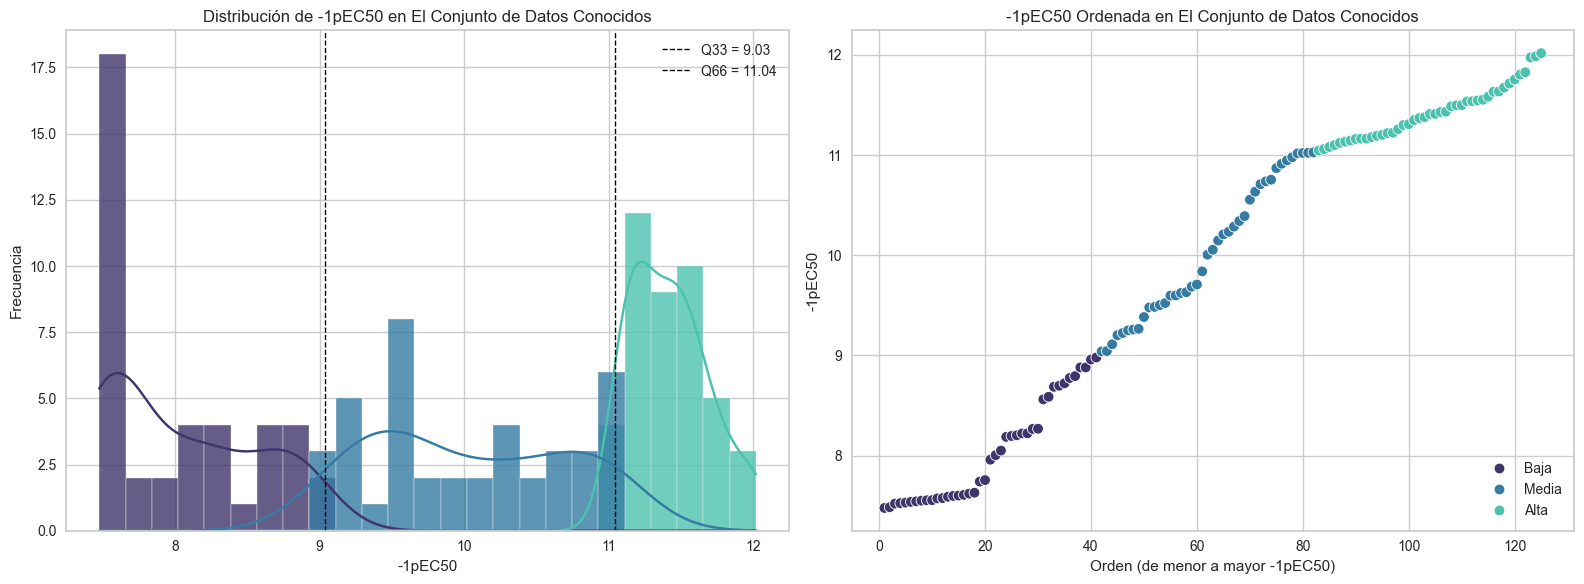


Resumen por categoría:
           n   promedio        min        max
Potencia                                     
Alta      43  11.421007  11.045275  12.017729
Baja      41   8.040037   7.476254   8.978810
Media     41  10.031697   9.039529  11.026872

Top 15 registros de categoría "Alta":


ID    -1pEC50 Potencia
116  seq_pep117  12.017729     Alta
25    seq_pep26  11.987163     Alta
6      seq_pep7  11.974694     Alta
10    seq_pep11  11.826814     Alta
92    seq_pep93  11.804100     Alta
57    seq_pep58  11.754487     Alta
26    seq_pep27  11.714442     Alta
114  seq_pep115  11.673664     Alta
55    seq_pep56  11.634512     Alta
9     seq_pep10  11.632644     Alta
117  seq_pep118  11.583360     Alta
84    seq_pep85  11.552842     Alta
63    seq_pep64  11.545156     Alta
42    seq_pep43  11.537602     Alta
78    seq_pep79  11.536107     Alta

In [18]:
# Clasificación y gráficos basados en cuantiles

%matplotlib inline 
clasificar_y_graficar_cuantiles(
    df_input=df_125_conocidos,   columna_valor='-1pEC50', 
    columna_id='ID', top_n=15,palette='mako',
    titulo_distribucion='Distribución de -1pEC50 en El Conjunto de Datos Conocidos',
    titulo_ordenado='-1pEC50 Ordenada en El Conjunto de Datos Conocidos')

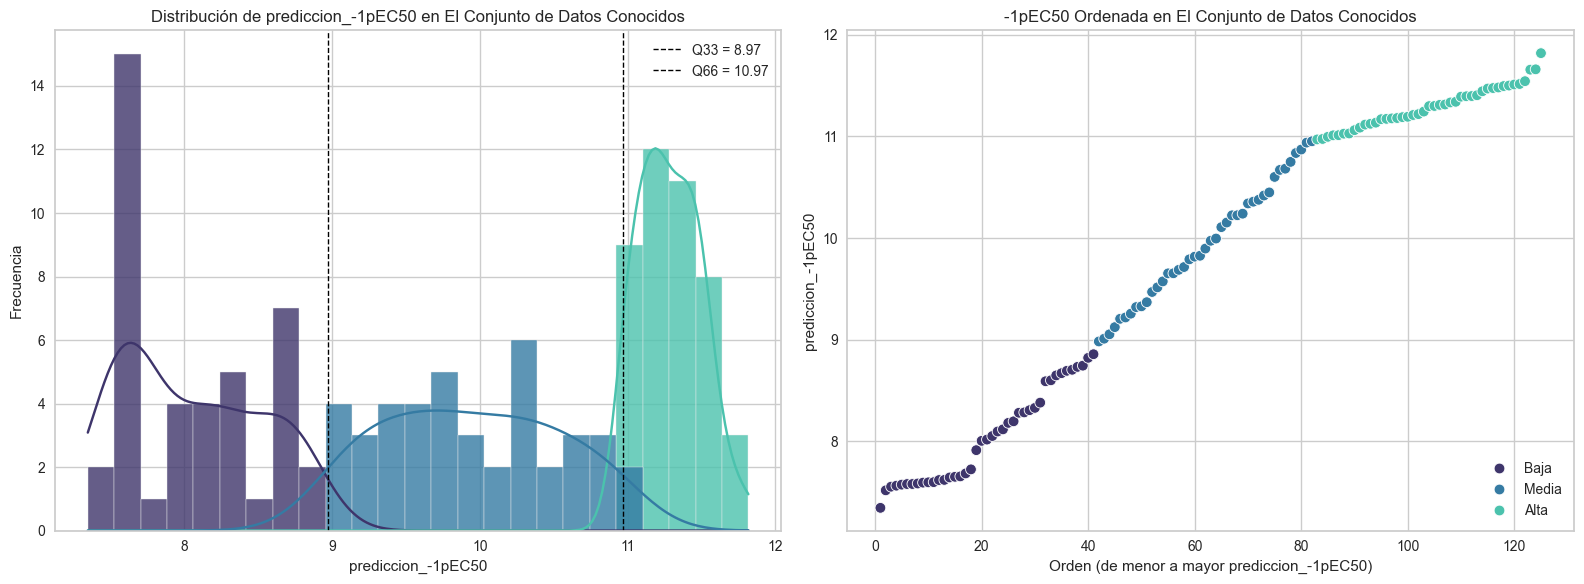


Resumen por categoría:
           n   promedio        min        max
Potencia                                     
Alta      43  11.286066  10.969144  11.817376
Baja      41   8.048172   7.347677   8.857814
Media     41   9.941857   8.983180  10.951030

Top 15 registros de categoría "Alta":


ID  prediccion_-1pEC50 Potencia
25    seq_pep26           11.817376     Alta
92    seq_pep93           11.658273     Alta
26    seq_pep27           11.655141     Alta
114  seq_pep115           11.541818     Alta
84    seq_pep85           11.514208     Alta
78    seq_pep79           11.509195     Alta
63    seq_pep64           11.498834     Alta
117  seq_pep118           11.493921     Alta
83    seq_pep84           11.479786     Alta
59    seq_pep60           11.474344     Alta
55    seq_pep56           11.469292     Alta
81    seq_pep82           11.442431     Alta
65    seq_pep66           11.403568     Alta
82    seq_pep83           11.395712     Alta
68    seq_pep69           11.393385     Alta

In [19]:
# Clasificación y gráficos basados en cuantiles

%matplotlib inline 
clasificar_y_graficar_cuantiles(
    df_input=df_125_conocidos,   columna_valor='prediccion_-1pEC50', 
    columna_id='ID', top_n=15,palette='mako',
    titulo_distribucion='Distribución de prediccion_-1pEC50 en El Conjunto de Datos Conocidos',
    titulo_ordenado='-1pEC50 Ordenada en El Conjunto de Datos Conocidos')

#### Predicción de actividad biológica para las secuencias de alta diversidad de GLP-1 obtenidas con cd-hit

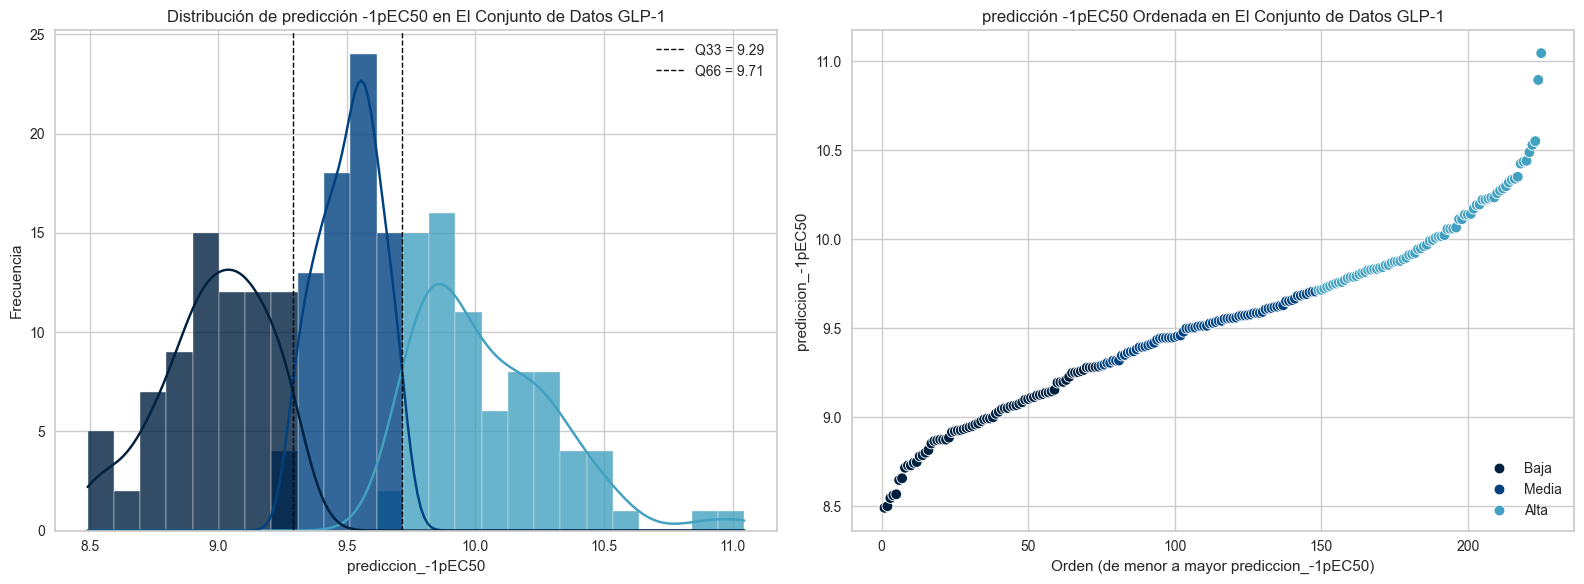


Resumen por categoría:
           n   promedio       min        max
Potencia                                    
Alta      77  10.045159  9.713811  11.045657
Baja      74   8.985231  8.491165   9.284582
Media     74   9.510922  9.290466   9.706269

Top 15 registros de categoría "Alta":


ID  prediccion_-1pEC50 Potencia
121  AF-A0A672I3H1-F1           11.045657     Alta
83   AF-A0A437DK50-F1           10.895120     Alta
181      AF-L5LRQ3-F1           10.551372     Alta
132  AF-A0A6J2R6I7-F1           10.530062     Alta
40   AF-A0A3B3B937-F1           10.489078     Alta
172      AF-G1Q6H7-F1           10.441206     Alta
144  AF-A0A7J7WHB7-F1           10.436451     Alta
58   AF-A0A3P8V3F5-F1           10.425306     Alta
17   AF-A0A1L3MY50-F1           10.351054     Alta
34   AF-A0A2S0D696-F1           10.340347     Alta
131  AF-A0A6J2IF30-F1           10.334754     Alta
220    XP_027996892.1           10.319579     Alta
189      AF-P13189-F1           10.297869     Alta
129  AF-A0A6I9NZD6-F1           10.285366     Alta
190      AF-P20394-F1           10.273668     Alta

In [20]:
# Clasificación y gráficos basados en cuantiles

%matplotlib inline 
clasificar_y_graficar_cuantiles(
    df_input=df_glp1,   columna_valor='prediccion_-1pEC50', 
    columna_id='ID', top_n=15,palette='ocean',
    titulo_distribucion='Distribución de predicción -1pEC50 en El Conjunto de Datos GLP-1',
    titulo_ordenado='predicción -1pEC50 Ordenada en El Conjunto de Datos GLP-1')

#### Predicción de actividad biológica para las secuencias obtenidas de la base de datos de Alphafold

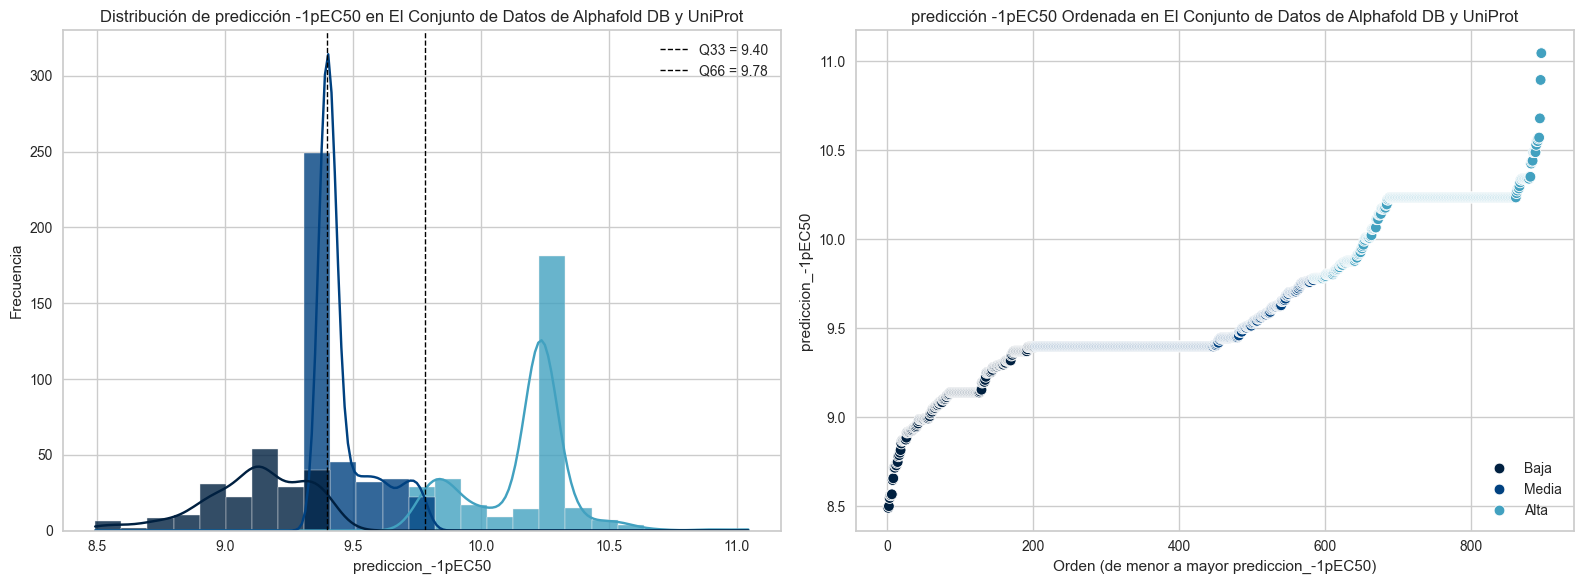


Resumen por categoría:
            n   promedio       min        max
Potencia                                     
Alta      313  10.155473  9.780633  11.045657
Baja      202   9.116771  8.491165   9.394925
Media     382   9.463666  9.398033   9.770343

Top 15 registros de categoría "Alta":


ID  prediccion_-1pEC50 Potencia
301  AF-A0A672I3H1-F1           11.045657     Alta
232  AF-A0A437DK50-F1           10.895120     Alta
739      AF-U3KRF3-F1           10.679161     Alta
587  AF-A0A7S9CE09-F1           10.571419     Alta
312  AF-A0A673HLN7-F1           10.565879     Alta
671      AF-L5LRQ3-F1           10.551372     Alta
768    XP_006766620.1           10.551372     Alta
357  AF-A0A6J2R6I7-F1           10.530062     Alta
184  AF-A0A3P9LIZ7-F1           10.489078     Alta
129  AF-A0A3B3B937-F1           10.489078     Alta
182  AF-A0A3P9IFL7-F1           10.489078     Alta
657      AF-H2LC36-F1           10.489078     Alta
641      AF-G1Q6H7-F1           10.441206     Alta
398  AF-A0A7J7WHB7-F1           10.436451     Alta
174  AF-A0A3P8V3F5-F1           10.425306     Alta

In [21]:
# Clasificación y gráficos basados en cuantiles

%matplotlib inline 
clasificar_y_graficar_cuantiles(
    df_input=df_glucagon_like_peptides,   columna_valor='prediccion_-1pEC50', 
    columna_id='ID', top_n=15,palette='ocean',
    titulo_distribucion='Distribución de predicción -1pEC50 en El Conjunto de Datos de Alphafold DB y UniProt',
    titulo_ordenado='predicción -1pEC50 Ordenada en El Conjunto de Datos de Alphafold DB y UniProt')

# Cálculo de propiedades fisicoquímicas Hemolisis, solubilidad y Nonfouling de los péptidos GLP-1 con peptideBert

In [22]:
from src.PeptideBert_predict import predict_peptidebert

### Calculo de las propiedades de Hemolisis, solubilidad y no-adherencia con PeptideBert

In [23]:
# Predicciones con PeptideBert para los 125 péptidos similares con actividad ec50 conocida
df_125_conocidos = predict_peptidebert(
    directorio_modelos_peptidebert,
    df_125_conocidos, 
    sequence_col='sequence',  # Le dices qué columna usar
    feats=['hemo', 'sol', 'nf']
)



Usando dispositivo: cuda
Procesando caracteristica: hemo


  0%|          | 0/125 [00:00<?, ?it/s]

Procesando caracteristica: sol


  0%|          | 0/125 [00:00<?, ?it/s]

Procesando caracteristica: nf


  0%|          | 0/125 [00:00<?, ?it/s]

In [24]:
#vista de resultados
df_125_conocidos[['ID', 'sequence', 'hemo', 'sol', 'nf']]

ID                              sequence      hemo       sol  \
0      seq_pep1        HSQGTFTSDYSKYLDSRRAQDFVQWLEEGE  0.055827  0.849804   
1      seq_pep2        HSQGTFTSDYSKYLDSRRAEDFVQWLENGE  0.052318  0.845523   
2      seq_pep3         HSQGTFTSDYSKYLDSRRAEDFVQWLENT  0.052129  0.786436   
3      seq_pep4  HSQGTFTSDYSKYLDSRRAEDFVQWLVAGGSGSGSG  0.055343  0.843368   
4      seq_pep5        HSQGTFTSDYSKYLDSRRAQDFVQWLEAEG  0.056414  0.811992   
..          ...                                   ...       ...       ...   
120  seq_pep121        HGEGTFTSDVSSYMERQSVDEFIAWLLKGR  0.067979  0.814278   
121  seq_pep122        HGEGTFTSDVSSYMESQLVDEFIAWLLKGR  0.078797  0.806707   
122  seq_pep123        HGEGTFTSDVSSYMEPQSTDEFIAWLLKGR  0.063813  0.838866   
123  seq_pep124        HGEGTFTSDVSSYMDFQSLVEFLAWLLKGR  0.084626  0.788322   
124  seq_pep125         HGEGTFTSDLSKQMDFESLVLFLEWLDNG  0.079532  0.814264   

           nf  
0    0.034196  
1    0.031188  
2    0.027671  
3    0.028107  
4    0.027693  
..        ...  
120  0.012806  
121  0.009764  
122  0.021915  
123  0.006998  
124  0.010483  

[125 rows x 5 columns]

In [25]:
# Predicciones con PeptideBert para el conjunto de alta diversidad
df_glp1 = predict_peptidebert(
    directorio_modelos_peptidebert,
    df_glp1, 
    sequence_col='sequence',  # Le dices qué columna usar
    feats=['hemo', 'sol', 'nf']
)

Usando dispositivo: cuda
Procesando caracteristica: hemo


  0%|          | 0/225 [00:00<?, ?it/s]

Procesando caracteristica: sol


  0%|          | 0/225 [00:00<?, ?it/s]

Procesando caracteristica: nf


  0%|          | 0/225 [00:00<?, ?it/s]

In [26]:
df_glp1[['ID', 'sequence', 'hemo', 'sol', 'nf']].head()

ID                        sequence      hemo       sol  \
0  AF-A0A060VXS0-F1  HAEGTYTSDMSSYLQDQAAKEFVSWLKNGR  0.051502  0.813716   
1  AF-A0A060VY52-F1  HAEGTYTSDVSSYLQDQAAKEFVSWLKNGR  0.054030  0.844703   
2  AF-A0A060WDT4-F1  HADGTYTSDVSTYLQDQAAKDFVSWLKSGL  0.068710  0.796401   
3  AF-A0A087VEU7-F1  HAEGTYTSDITSYLEGQAAKEFIAWLVNGR  0.066916  0.730178   
4  AF-A0A087XPV4-F1  HADGTFTSDVSSYLKDQAIKDFVAQLKSGQ  0.059716  0.807739   

         nf  
0  0.023509  
1  0.020588  
2  0.016539  
3  0.009954  
4  0.020352

In [27]:
# Predicciones con PeptideBert para el conjunto obtenido de la base de datos de Aphafold
df_glucagon_like_peptides = predict_peptidebert(
    directorio_modelos_peptidebert,
    df_glucagon_like_peptides, 
    sequence_col='sequence',  # Le dices qué columna usar
    feats=['hemo', 'sol', 'nf']
)

Usando dispositivo: cuda
Procesando caracteristica: hemo


  0%|          | 0/897 [00:00<?, ?it/s]

Procesando caracteristica: sol


  0%|          | 0/897 [00:00<?, ?it/s]

Procesando caracteristica: nf


  0%|          | 0/897 [00:00<?, ?it/s]

In [28]:
df_glucagon_like_peptides[['ID', 'sequence', 'hemo', 'sol', 'nf']]

ID                        sequence      hemo  \
0                  AF-A0A060VXS0-F1  HAEGTYTSDMSSYLQDQAAKEFVSWLKNGR  0.051502   
1                  AF-A0A060VY52-F1  HAEGTYTSDVSSYLQDQAAKEFVSWLKNGR  0.054030   
2                  AF-A0A060WDT4-F1  HADGTYTSDVSTYLQDQAAKDFVSWLKSGL  0.068710   
3                  AF-A0A087VEU7-F1  HAEGTYTSDITSYLEGQAAKEFIAWLVNGR  0.066916   
4                  AF-A0A087XPV4-F1  HADGTFTSDVSSYLKDQAIKDFVAQLKSGQ  0.059716   
..                              ...                             ...       ...   
892  tr-A0A8C9ICK2-A0A8C9ICK2_9PRIM  HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR  0.066893   
893  tr-A0A8I3QXE0-A0A8I3QXE0_CANLF  HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR  0.066893   
894          tr-F7ID40-F7ID40_CALJA  HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR  0.066893   
895          tr-G1TRR9-G1TRR9_RABIT  HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR  0.066893   
896          tr-G3QHC4-G3QHC4_GORGO  HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR  0.066893   

          sol        nf  
0    0.813716  0.023509  
1    0.844703  0.020588  
2    0.796401  0.016539  
3    0.730178  0.009954  
4    0.807739  0.020352  
..        ...       ...  
892  0.825296  0.009175  
893  0.825296  0.009175  
894  0.825296  0.009175  
895  0.825296  0.009175  
896  0.825296  0.009175  

[897 rows x 5 columns]

In [29]:
# obtener los resultados del pro-glucagon Humano como referencia
df_pro_glucagon_humano = df_glucagon_like_peptides[df_glucagon_like_peptides['ID'].str.contains("human", case=False, na=False)]
df_pro_glucagon_humano[['ID','Description','sequence','Species', 'sol', 'hemo', 'nf']]

ID Description                        sequence  \
875  sp-P01275-GLUC_HUMAN    Glucagon  HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR   

             Species       sol      hemo        nf  
875  Pan troglodytes  0.825296  0.066893  0.009175

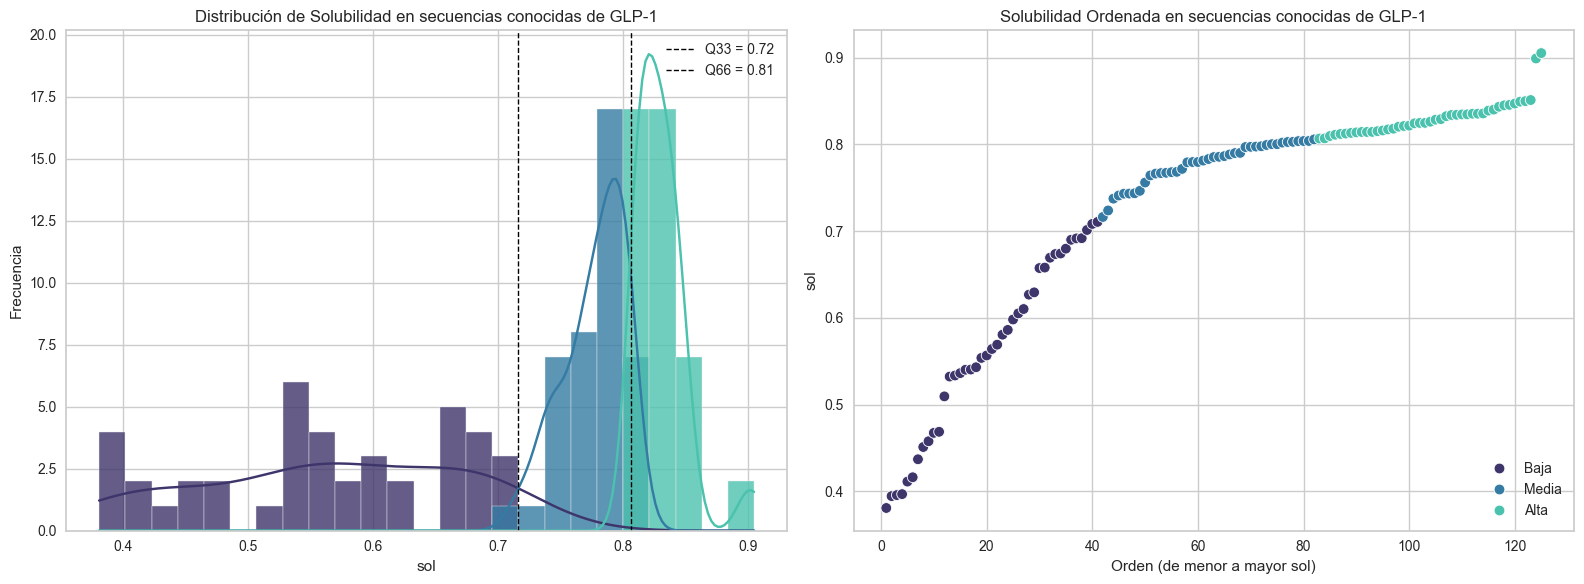


Resumen por categoría:
           n  promedio       min       max
Potencia                                  
Alta      43  0.830344  0.806707  0.905196
Baja      41  0.563361  0.380827  0.710580
Media     41  0.777207  0.716259  0.805688

Top 15 registros de categoría "Alta":


ID       sol Potencia
46    seq_pep47  0.905196     Alta
47    seq_pep48  0.898952     Alta
110  seq_pep111  0.851075     Alta
0      seq_pep1  0.849804     Alta
12    seq_pep13  0.849240     Alta
10    seq_pep11  0.847004     Alta
1      seq_pep2  0.845523     Alta
52    seq_pep53  0.844946     Alta
3      seq_pep4  0.843368     Alta
11    seq_pep12  0.840037     Alta
122  seq_pep123  0.838866     Alta
9     seq_pep10  0.835602     Alta
87    seq_pep88  0.835365     Alta
113  seq_pep114  0.835304     Alta
81    seq_pep82  0.834569     Alta

In [30]:
# Clasificación y gráficos basados en cuantiles de solubilidad
clasificar_y_graficar_cuantiles(
    df_input=df_125_conocidos,   columna_valor='sol', 
    columna_id='ID', top_n=15,palette='mako',
    titulo_distribucion='Distribución de Solubilidad en secuencias conocidas de GLP-1',
    titulo_ordenado='Solubilidad Ordenada en secuencias conocidas de GLP-1'
)

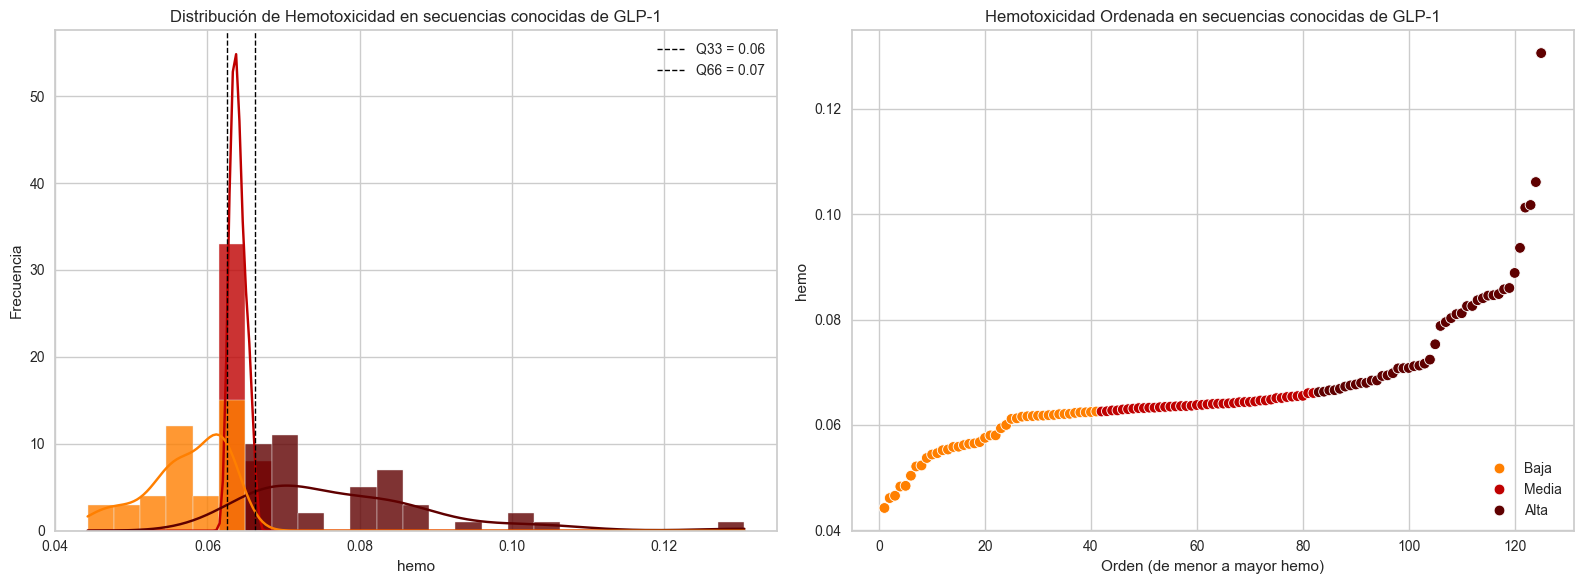


Resumen por categoría:
           n  promedio       min       max
Potencia                                  
Alta      43  0.078426  0.066235  0.130579
Baja      41  0.057206  0.044251  0.062554
Media     41  0.064023  0.062560  0.066066

Top 15 registros de categoría "Alta":


ID      hemo Potencia
45    seq_pep46  0.130579     Alta
6      seq_pep7  0.106102     Alta
46    seq_pep47  0.101750     Alta
8      seq_pep9  0.101251     Alta
7      seq_pep8  0.093613     Alta
119  seq_pep120  0.088852     Alta
17    seq_pep18  0.085996     Alta
16    seq_pep17  0.085746     Alta
22    seq_pep23  0.084847     Alta
123  seq_pep124  0.084626     Alta
21    seq_pep22  0.084552     Alta
15    seq_pep16  0.084058     Alta
20    seq_pep21  0.083676     Alta
13    seq_pep14  0.082585     Alta
18    seq_pep19  0.082567     Alta

In [31]:
# Clasificación y gráficos basados en cuantiles de solubilidad
clasificar_y_graficar_cuantiles(
    df_input=df_125_conocidos,   columna_valor='hemo', 
    columna_id='ID', top_n=15,palette='gist_heat_r',
    titulo_distribucion='Distribución de Hemotoxicidad en secuencias conocidas de GLP-1',
    titulo_ordenado='Hemotoxicidad Ordenada en secuencias conocidas de GLP-1'
)

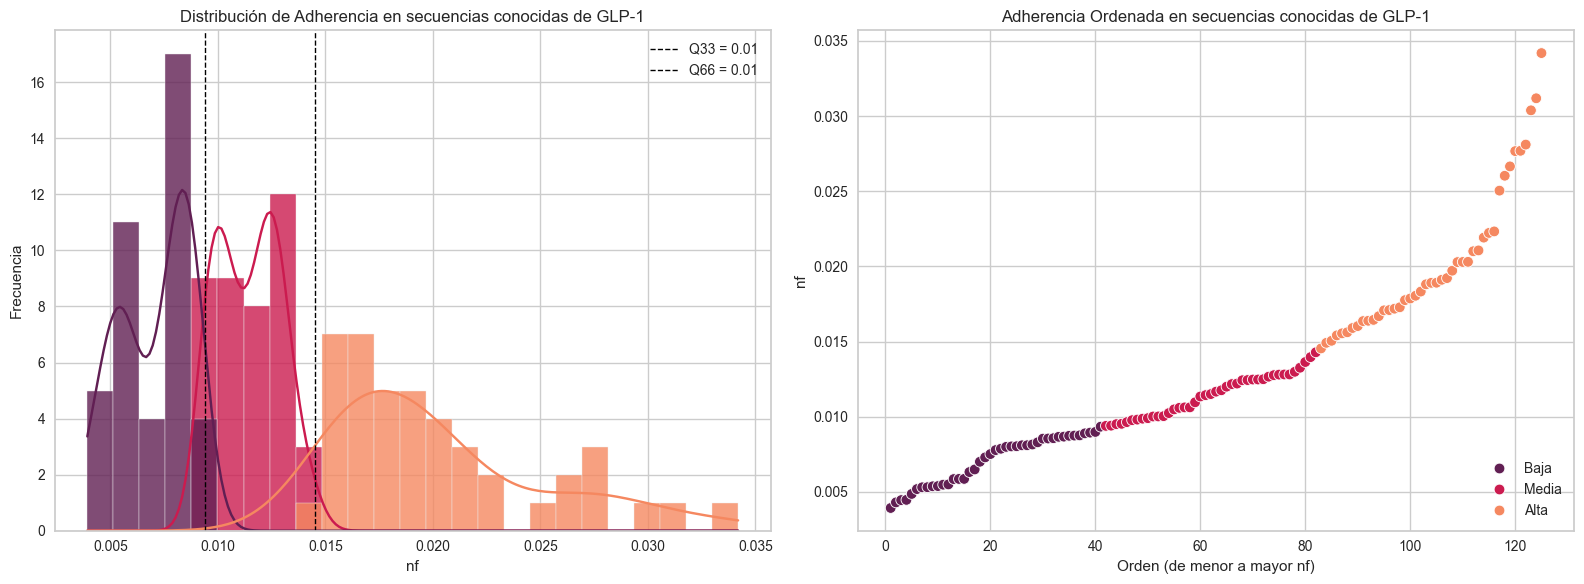


Resumen por categoría:
           n  promedio       min       max
Potencia                                  
Alta      43  0.020245  0.014541  0.034196
Baja      41  0.007055  0.003922  0.009333
Media     41  0.011430  0.009386  0.014283

Top 15 registros de categoría "Alta":


ID        nf Potencia
0      seq_pep1  0.034196     Alta
1      seq_pep2  0.031188     Alta
86    seq_pep87  0.030385     Alta
3      seq_pep4  0.028107     Alta
4      seq_pep5  0.027693     Alta
2      seq_pep3  0.027671     Alta
5      seq_pep6  0.026654     Alta
12    seq_pep13  0.026033     Alta
10    seq_pep11  0.025042     Alta
64    seq_pep65  0.022327     Alta
80    seq_pep81  0.022228     Alta
122  seq_pep123  0.021915     Alta
67    seq_pep68  0.021063     Alta
47    seq_pep48  0.021006     Alta
66    seq_pep67  0.020303     Alta

In [32]:
# Grafico de la Adherencia de las secuencias generadas
clasificar_y_graficar_cuantiles(
    df_input=df_125_conocidos,   columna_valor='nf', 
    columna_id='ID', top_n=15, palette='rocket',
    titulo_distribucion='Distribución de Adherencia en secuencias conocidas de GLP-1',
    titulo_ordenado='Adherencia Ordenada en secuencias conocidas de GLP-1'
)


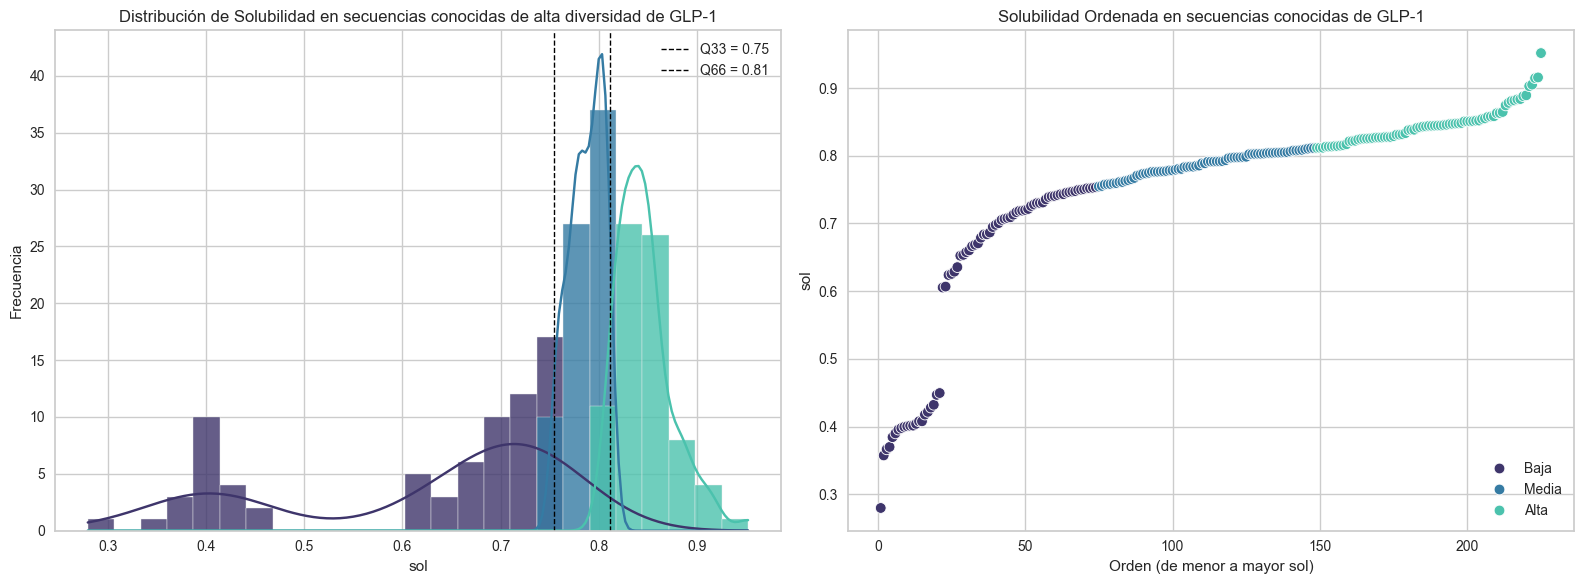


Resumen por categoría:
           n  promedio       min       max
Potencia                                  
Alta      77  0.846210  0.811645  0.951705
Baja      74  0.618319  0.279729  0.753454
Media     74  0.787171  0.754591  0.811238

Top 15 registros de categoría "Alta":


ID       sol Potencia
143  AF-A0A7J5Z6B7-F1  0.951705     Alta
204      AF-Q7LZN2-F1  0.915737     Alta
167      AF-C0HJJ5-F1  0.914667     Alta
165      AF-C0HJJ3-F1  0.905193     Alta
206      AF-Q7LZN4-F1  0.902802     Alta
168      AF-C0HJJ6-F1  0.889321     Alta
76   AF-A0A3Q3FFF5-F1  0.887957     Alta
214       Dulaglutide  0.883833     Alta
222    XP_029460758.1  0.883336     Alta
217    NP_001079142.1  0.881748     Alta
177      AF-G3PL47-F1  0.881021     Alta
113  AF-A0A668UCV8-F1  0.878192     Alta
169      AF-C6EVG1-F1  0.874423     Alta
51   AF-A0A3B4GZV8-F1  0.864719     Alta
210      AF-Q9PUR0-F1  0.863256     Alta

In [33]:
# Clasificación y gráficos basados en cuantiles de solubilidad
clasificar_y_graficar_cuantiles(
    df_input=df_glp1,   columna_valor='sol', 
    columna_id='ID', top_n=15,palette='mako',
    titulo_distribucion='Distribución de Solubilidad en secuencias conocidas de alta diversidad de GLP-1',
    titulo_ordenado='Solubilidad Ordenada en secuencias conocidas de GLP-1'
)

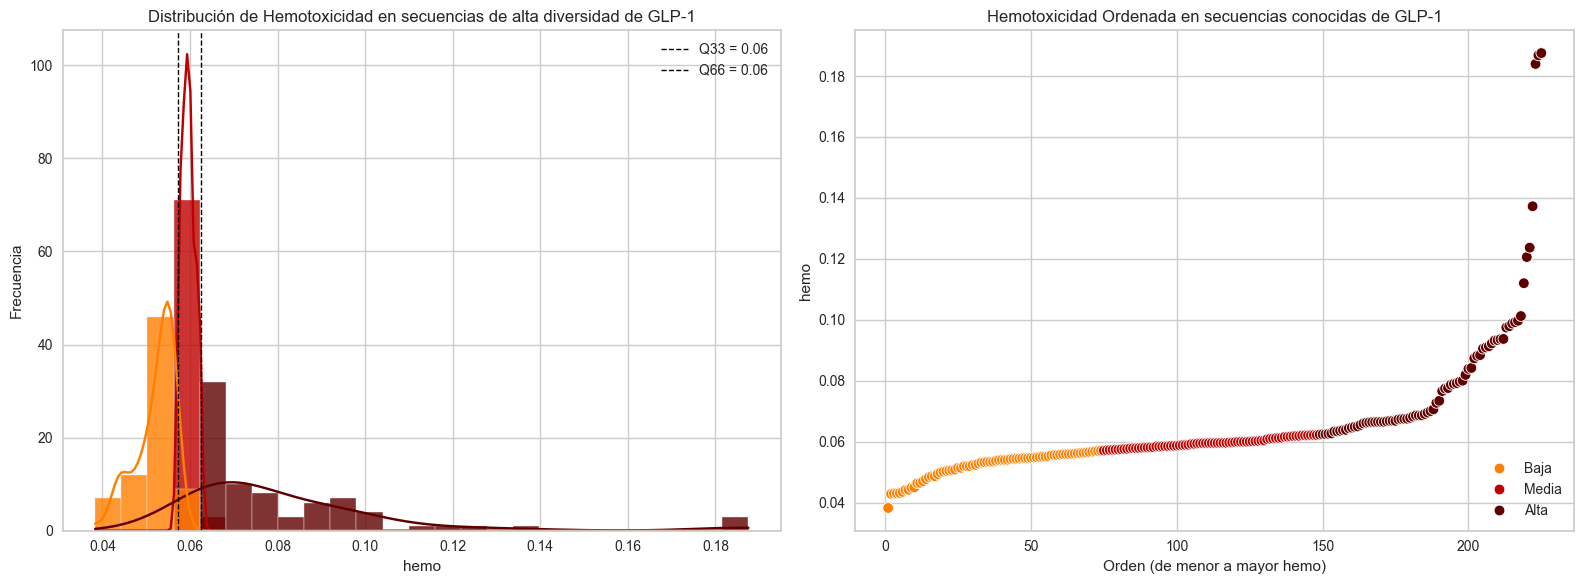


Resumen por categoría:
           n  promedio       min       max
Potencia                                  
Alta      77  0.082112  0.062419  0.187523
Baja      74  0.052089  0.038335  0.057144
Media     74  0.059623  0.057190  0.062262

Top 15 registros de categoría "Alta":


ID      hemo Potencia
152  AF-A0A7L1V7B0-F1  0.187523     Alta
149  AF-A0A7K8VMT8-F1  0.186778     Alta
147  AF-A0A7K5DTR4-F1  0.183961     Alta
108  AF-A0A667XFV4-F1  0.137271     Alta
175      AF-G1QFC1-F1  0.123714     Alta
64   AF-A0A3Q0ST55-F1  0.120623     Alta
24   AF-A0A1S3NVN9-F1  0.112043     Alta
7    AF-A0A091P079-F1  0.101275     Alta
180      AF-H9GKR8-F1  0.099744     Alta
160  AF-A0A7L3GS93-F1  0.099264     Alta
159  AF-A0A7L3G0X3-F1  0.098834     Alta
154  AF-A0A7L2JAW6-F1  0.097947     Alta
156  AF-A0A7L2RU62-F1  0.097509     Alta
153  AF-A0A7L1V7E8-F1  0.093772     Alta
158  AF-A0A7L2YV14-F1  0.093714     Alta

In [34]:
# Clasificación y gráficos basados en cuantiles de solubilidad
clasificar_y_graficar_cuantiles(
    df_input=df_glp1,   columna_valor='hemo', 
    columna_id='ID', top_n=15,palette='gist_heat_r',
    titulo_distribucion='Distribución de Hemotoxicidad en secuencias de alta diversidad de GLP-1',
    titulo_ordenado='Hemotoxicidad Ordenada en secuencias conocidas de GLP-1'
)

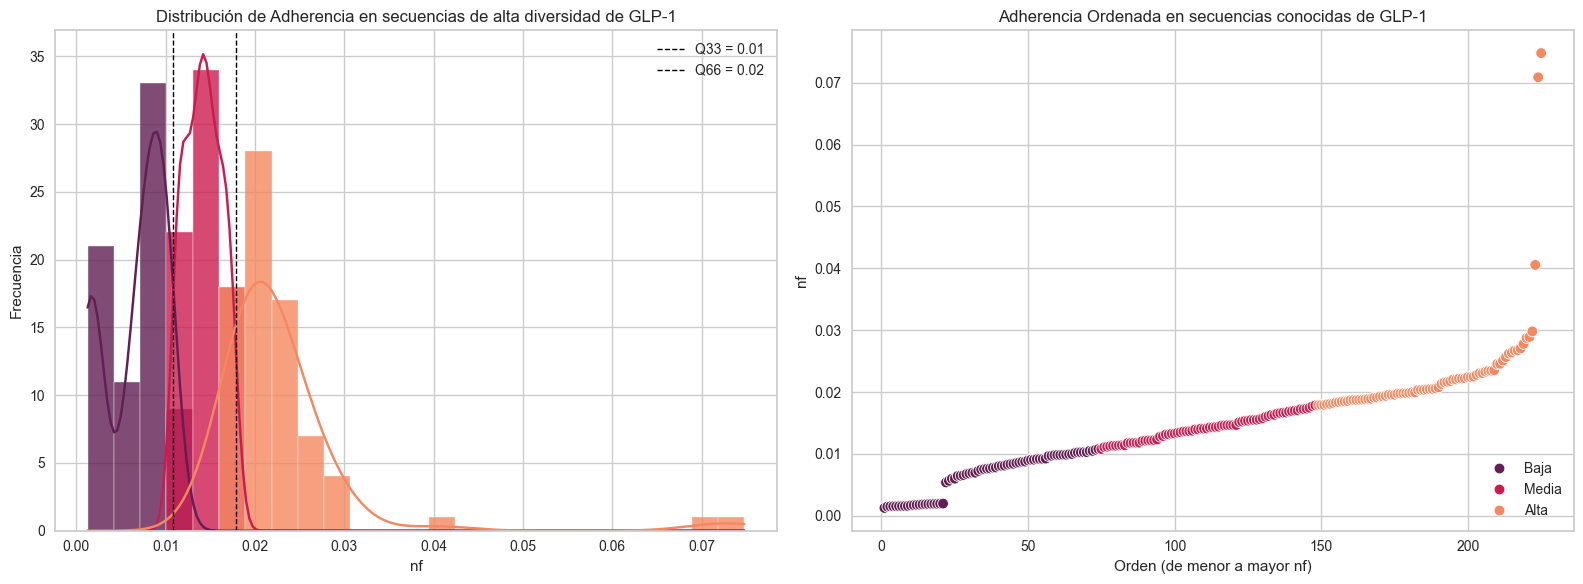


Resumen por categoría:
           n  promedio       min       max
Potencia                                  
Alta      77  0.022981  0.017887  0.074783
Baja      74  0.006612  0.001266  0.010794
Media     74  0.014216  0.010799  0.017850

Top 15 registros de categoría "Alta":


ID        nf Potencia
123  AF-A0A672NPW9-F1  0.074783     Alta
135  AF-A0A6P6M3Y7-F1  0.070871     Alta
188      AF-P0C235-F1  0.040546     Alta
124  AF-A0A672Q9F1-F1  0.029796     Alta
118  AF-A0A671T9R4-F1  0.028904     Alta
23   AF-A0A1S3MVQ3-F1  0.028741     Alta
207      AF-Q9DDE6-F1  0.027780     Alta
86   AF-A0A498N7U8-F1  0.027058     Alta
91   AF-A0A4W4FPL9-F1  0.026756     Alta
199      AF-Q6RYB3-F1  0.026699     Alta
194      AF-P68956-F1  0.026380     Alta
102  AF-A0A5C6PPH3-F1  0.026214     Alta
208      AF-Q9DG43-F1  0.025648     Alta
133  AF-A0A6J2V6I4-F1  0.025084     Alta
193      AF-P68274-F1  0.024579     Alta

In [35]:
# Grafico de la Adherencia de las secuencias generadas
clasificar_y_graficar_cuantiles(
    df_input=df_glp1,   columna_valor='nf', 
    columna_id='ID', top_n=15, palette='rocket',
    titulo_distribucion='Distribución de Adherencia en secuencias de alta diversidad de GLP-1',
    titulo_ordenado='Adherencia Ordenada en secuencias conocidas de GLP-1'
)


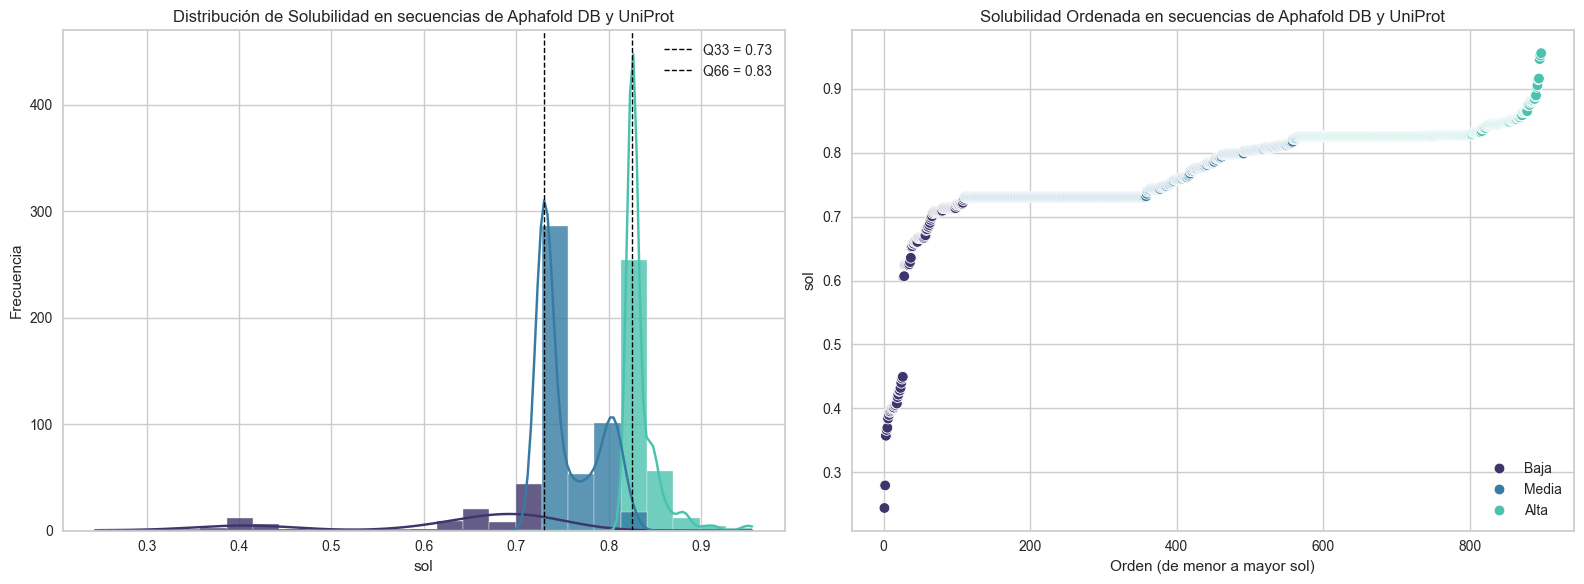


Resumen por categoría:
            n  promedio       min       max
Potencia                                   
Alta      329  0.834488  0.825296  0.955395
Baja      110  0.617864  0.244463  0.728038
Media     458  0.755570  0.730178  0.824885

Top 15 registros de categoría "Alta":


ID       sol Potencia
704      AF-Q6IUP8-F1  0.955395     Alta
394  AF-A0A7J5Z6B7-F1  0.951705     Alta
312  AF-A0A673HLN7-F1  0.946053     Alta
720      AF-Q7LZN2-F1  0.915737     Alta
630      AF-C0HJJ5-F1  0.914667     Alta
628      AF-C0HJJ3-F1  0.905193     Alta
722      AF-Q7LZN4-F1  0.902802     Alta
631      AF-C0HJJ6-F1  0.889321     Alta
219  AF-A0A3Q3FFF5-F1  0.887957     Alta
745       Dulaglutide  0.883833     Alta
820    XP_029460758.1  0.883336     Alta
750    NP_001079142.1  0.881748     Alta
649      AF-G3PL53-F1  0.881021     Alta
648      AF-G3PL47-F1  0.881021     Alta
587  AF-A0A7S9CE09-F1  0.880162     Alta

In [36]:
# Clasificación y gráficos basados en cuantiles de solubilidad
clasificar_y_graficar_cuantiles(
    df_input=df_glucagon_like_peptides,   columna_valor='sol', 
    columna_id='ID', top_n=15,palette='mako',
    titulo_distribucion='Distribución de Solubilidad en secuencias de Aphafold DB y UniProt',
    titulo_ordenado='Solubilidad Ordenada en secuencias de Aphafold DB y UniProt'
)

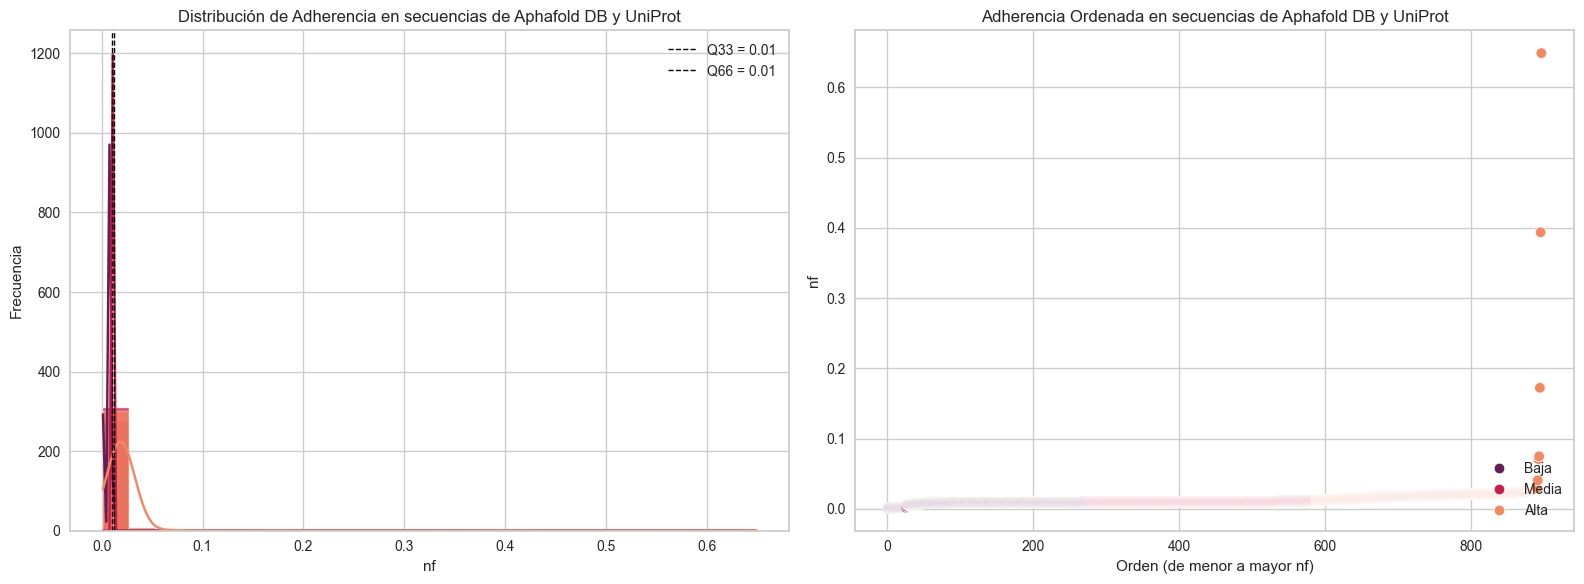


Resumen por categoría:
            n  promedio       min       max
Potencia                                   
Alta      311  0.022861  0.012247  0.648717
Baja      277  0.008192  0.001266  0.009868
Media     309  0.010213  0.009954  0.012194

Top 15 registros de categoría "Alta":


ID        nf Potencia
312  AF-A0A673HLN7-F1  0.648717     Alta
587  AF-A0A7S9CE09-F1  0.393677     Alta
313  AF-A0A673HMH6-F1  0.172374     Alta
304  AF-A0A672NPW9-F1  0.074783     Alta
374  AF-A0A6P6M3Y7-F1  0.070871     Alta
684      AF-P0C235-F1  0.040546     Alta
306  AF-A0A672Q9F1-F1  0.029796     Alta
297  AF-A0A671T9R4-F1  0.028904     Alta
725      AF-Q91189-F1  0.028741     Alta
57   AF-A0A1S3MVQ3-F1  0.028741     Alta
727      AF-Q9DDE6-F1  0.027780     Alta
239  AF-A0A498N7U8-F1  0.027058     Alta
247  AF-A0A4W4FPL9-F1  0.026756     Alta
710      AF-Q6RYB3-F1  0.026699     Alta
694      AF-P68956-F1  0.026380     Alta

In [37]:
# Grafico de la Adherencia de las secuencias generadas
clasificar_y_graficar_cuantiles(
    df_input=df_glucagon_like_peptides,   columna_valor='nf', 
    columna_id='ID', top_n=15, palette='rocket',
    titulo_distribucion='Distribución de Adherencia en secuencias de Aphafold DB y UniProt',
    titulo_ordenado='Adherencia Ordenada en secuencias de Aphafold DB y UniProt'
)

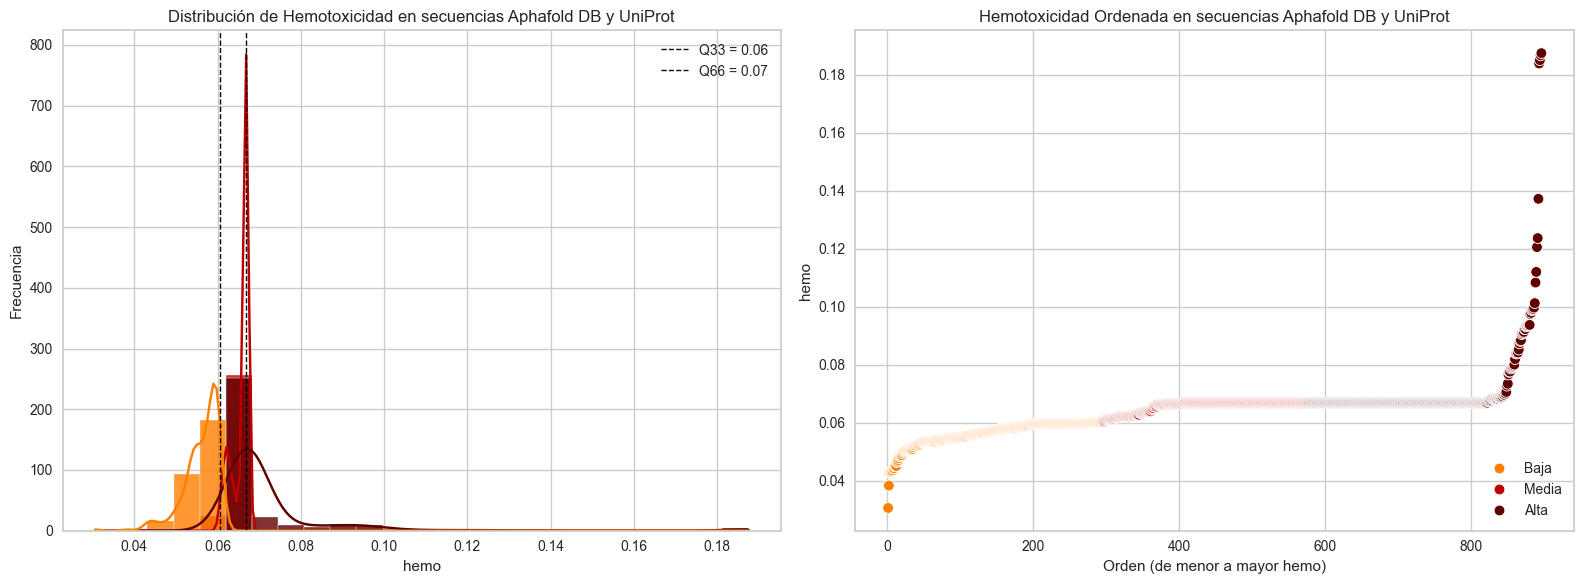


Resumen por categoría:
            n  promedio       min       max
Potencia                                   
Alta      321  0.071912  0.066916  0.187523
Baja      295  0.056162  0.030618  0.060451
Media     281  0.065712  0.060497  0.066893

Top 15 registros de categoría "Alta":


ID      hemo Potencia
537  AF-A0A7L1V7B0-F1  0.187523     Alta
485  AF-A0A7K8VMT8-F1  0.186778     Alta
313  AF-A0A673HMH6-F1  0.185114     Alta
417  AF-A0A7K5DTR4-F1  0.183961     Alta
279  AF-A0A667XFV4-F1  0.137271     Alta
644      AF-G1QFC1-F1  0.123714     Alta
188  AF-A0A3Q0ST55-F1  0.120623     Alta
58   AF-A0A1S3NVN9-F1  0.112043     Alta
704      AF-Q6IUP8-F1  0.108387     Alta
13   AF-A0A091P079-F1  0.101275     Alta
663      AF-H9GKR8-F1  0.099744     Alta
564  AF-A0A7L3GS93-F1  0.099264     Alta
569  AF-A0A7L3M3E7-F1  0.099080     Alta
563  AF-A0A7L3G0X3-F1  0.098834     Alta
545  AF-A0A7L2JAW6-F1  0.097947     Alta

In [38]:
# Clasificación y gráficos basados en cuantiles de solubilidad
clasificar_y_graficar_cuantiles(
    df_input=df_glucagon_like_peptides,   columna_valor='hemo', 
    columna_id='ID', top_n=15,palette='gist_heat_r',
    titulo_distribucion='Distribución de Hemotoxicidad en secuencias Aphafold DB y UniProt',
    titulo_ordenado='Hemotoxicidad Ordenada en secuencias Aphafold DB y UniProt'
)

### Generación de nuevas secuencias usando modelo generatívo

Se selecionan las secuencias de todos los conjuntos tomando como criteros la actividad, solubilidad, y no adherencia

In [39]:
# Union de los conjuntos de datos previo a la generación de nuevas secuencias

#unir todos los peptidos evaluados en un solo dataframe
df_todos_peptidos = pd.concat([df_pro_glucagon_humano, df_glucagon_like_peptides,df_125_conocidos, df_glp1, ], ignore_index=True)
# Eliminación de duplicados por secuencia
#df_todos_peptidos = df_todos_peptidos.drop_duplicates(subset=['sequence'])
df_todos_peptidos.shape

(1248, 1302)

### Como linea extra de investigación buscamos las especies de los péptidos con mayor actividad biológica a partir de los datos obtenidos de alpha fold

In [40]:
df_pro_glucagon_humano[['ID', 'Description', 'Species','organismCommonNames', 'prediccion_-1pEC50', 'sol', 'hemo', 'nf']]

ID Description          Species organismCommonNames  \
875  sp-P01275-GLUC_HUMAN    Glucagon  Pan troglodytes          Chimpanzee   

     prediccion_-1pEC50       sol      hemo        nf  
875           10.234846  0.825296  0.066893  0.009175

In [41]:
# buscar los compuestos con mayor actividad de los que se conoce la especie

df_mejores_especies = df_todos_peptidos[df_todos_peptidos['Species'].notnull()].sort_values(by='prediccion_-1pEC50', ascending=False)
df_mejores_especies[['ID', 'Description', 'Species','organismCommonNames', 'prediccion_-1pEC50', 'sol', 'hemo', 'nf']].head(30)

ID                         Description  \
302  AF-A0A672I3H1-F1                          Glucagon a   
233  AF-A0A437DK50-F1             Uncharacterized protein   
740      AF-U3KRF3-F1                         Liraglutide   
588  AF-A0A7S9CE09-F1             Glucagon-like peptide 1   
313  AF-A0A673HLN7-F1  GLUCAGON domain-containing protein   
672      AF-L5LRQ3-F1                            Glucagon   
358  AF-A0A6J2R6I7-F1                     glucagon-1-like   
658      AF-H2LC36-F1             Uncharacterized protein   
183  AF-A0A3P9IFL7-F1                            Glucagon   
185  AF-A0A3P9LIZ7-F1                          Glucagon a   
130  AF-A0A3B3B937-F1                          Glucagon-1   
642      AF-G1Q6H7-F1                            Glucagon   
399  AF-A0A7J7WHB7-F1                            Glucagon   
175  AF-A0A3P8V3F5-F1                          Glucagon a   
47   AF-A0A1L3MY50-F1                            Glucagon   
95   AF-A0A2S0D696-F1                   Preproglucagon A2   
102  AF-A0A2S0D707-F1                   Preproglucagon B1   
290  AF-A0A670IXF6-F1             Uncharacterized protein   
291  AF-A0A670IXG1-F1  GLUCAGON domain-containing protein   
289  AF-A0A670IWE2-F1  GLUCAGON domain-containing protein   
97   AF-A0A2S0D698-F1                   Preproglucagon A1   
98   AF-A0A2S0D699-F1                  Preproglucagon B2s   
101  AF-A0A2S0D6T7-F1                  Preproglucagon A2s   
103  AF-A0A2S0D708-F1                   Preproglucagon B2   
587  AF-A0A7R5KHT1-F1        pro-glucagon-like isoform X1   
357  AF-A0A6J2IF30-F1           exendin-3-like isoform X2   
686      AF-P13189-F1                            Glucagon   
389  AF-A0A6P8U7R0-F1                     glucagon-1-like   
346  AF-A0A6I9NZD6-F1                     glucagon-1-like   
688      AF-P20394-F1                           Exendin-3   

                                     Species      organismCommonNames  \
302                       Salarias fasciatus          Jewelled blenny   
233                        Oryzias javanicus                      NaN   
740                 Saccharomyces cerevisiae                      NaN   
588  Emberiza bruniceps (red-headed bunting)                      NaN   
313             Sinocyclocheilus rhinocerous                      NaN   
672                           Myotis davidii           David's myotis   
358                         Cottoperca gobio                      NaN   
658                          Oryzias latipes                      NaN   
183                          Oryzias latipes       Japanese rice fish   
185                          Oryzias latipes       Japanese rice fish   
130                       Oryzias melastigma            Marine medaka   
642                         Myotis lucifugus         Little brown bat   
399                            Myotis myotis  Greater mouse-eared bat   
175                   Cynoglossus semilaevis              Tongue sole   
47                  Ornithorhynchus anatinus        Duckbill platypus   
95                 Takydromus tachydromoides                      NaN   
102                Takydromus tachydromoides                      NaN   
290                         Podarcis muralis                      NaN   
291                         Podarcis muralis              Wall lizard   
289                         Podarcis muralis              Wall lizard   
97                 Takydromus tachydromoides                      NaN   
98                 Takydromus tachydromoides                      NaN   
101                Takydromus tachydromoides                      NaN   
103                Takydromus tachydromoides                      NaN   
587    Pipra filicauda (Wire-tailed manakin)                      NaN   
357    Pipra filicauda (Wire-tailed manakin)                      NaN   
686                      Callorhinchus milii              Ghost shark   
389                     Gymnodraco acuticeps                      NaN   
346     No

### Ligas a las descripciones de las especies con mejores péptidos agonistas de GLP-1

[Salarias fasciatus](https://es.wikipedia.org/wiki/Salarias_fasciatus)


[Oryzias javanicus](https://es.wikipedia.org/wiki/Oryzias_javanicus)


[Liraglutida](https://es.wikipedia.org/wiki/Liraglutida)


[Saccharomyces cerevisiae](https://es.wikipedia.org/wiki/Saccharomyces_cerevisiae)


[Emberiza bruniceps](https://es.wikipedia.org/wiki/Emberiza_bruniceps)


[Sinocyclocheilus rhinocerous](https://es.wikipedia.org/wiki/Sinocyclocheilus_rhinocerous)


[David's myotis](https://en.wikipedia.org/wiki/David%27s_myotis)


[Cottoperca gobio](https://en.wikipedia.org/wiki/Cottoperca_gobio)


[Oryzias latipes](https://es.wikipedia.org/wiki/Oryzias_latipes)


[Myotis lucifugus](https://es.wikipedia.org/wiki/Myotis_lucifugus)

In [42]:
# Selección de los mejores péptidos según múltiples criterios

df_seleccionadas = df_todos_peptidos.drop_duplicates('sequence').sort_values(by=['prediccion_-1pEC50','sol','hemo','nf'], ascending=[False, False, True, True])
# Filtrar predicciones con pEC50 > 10.5 y longitud <= 60
df_seleccionadas = df_seleccionadas[
    (df_seleccionadas['prediccion_-1pEC50'] > 10.6) & 
    (df_seleccionadas['sequence'].str.len() <= 60)]

df_seleccionadas.info()
display(df_seleccionadas[["ID","sequence","prediccion_-1pEC50","sol","hemo","nf","Species","organismCommonNames"]])

<class 'pandas.core.frame.DataFrame'>
Index: 54 entries, 923 to 932
Columns: 1302 entries, ID to -1pEC50
dtypes: category(3), float32(1293), float64(4), object(2)
memory usage: 311.8+ KB


ID                                   sequence  \
923          seq_pep26    YSEGTFTSDYSKLLEEEAVRDFIEWLLAGGPSSGAPPPS   
990          seq_pep93              HSQGTFTSDYSKYLDSRAASEFVQWLISE   
924          seq_pep27    YSEGTFTSDYSKLLERQAIDEFVNWLLKGGPSSGAPPPS   
1012        seq_pep115              HAEGTFTSDVSSYLEGQAAKEFIAWLKGR   
982          seq_pep85             HSQGTFTSDYSKYLDSERARDFVAWLVAGG   
976          seq_pep79             HSIGTFTSDYSKYLDSERARDFVQWLVAGG   
961          seq_pep64             HSQGTFTSDYSKYLDSRSARDFVQWLVAGG   
1015        seq_pep118              HSQGTFTSDYSKYLEEEAVRLFICWLMNT   
981          seq_pep84             HSQGTFTSDYSKYLDSERARDFVEWLVAGG   
957          seq_pep60              HSQGTFTSDYSKYLDSRRASEFVQWLISG   
953          seq_pep56             HAEGTFTSDVSAYLEGQAAKEFIAWLVKGR   
979          seq_pep82             HSQGTFTSDYSKYLESERARDFVQWLVAGG   
963          seq_pep66             HSQGTFTSDYSKYLDEAAASDFVQWLVAGG   
980          seq_pep83             HSQGTFTSDYSKYLDSERAREFVQWLVAGG   
966          seq_pep69             HSQGTFTSDYSKYLDSERARDFVQWLVAGG   
985          seq_pep88             HSQGTFTSEYSKYLDSERARDFVQWLVAGG   
989          seq_pep92              HSQGTFTSDYSRYLDSRRASEFVQWLISE   
921          seq_pep24    YSEGTFTSDYSKLKEEEANRLFIEWLLAGGPSSGAPPPS   
904           seq_pep7              YSQGTFTSDYSKYLEEEAVRLFIEWLLAG   
964          seq_pep67             HSQGTFTSDYSKYLDSEAASDFVQWLVAGG   
960          seq_pep63             HSQGTFTSDYSKYLDRAAASDFVQWLVAGG   
978          seq_pep81             HSQGTFTSDYSEYLDSERARDFVQWLVAGG   
962          seq_pep65             HSQGTFTSDYSKYLDSRSASDFVQWLVAGG   
959          seq_pep62              HSQGTFTSDYSKYLDSRRASEFVQWLISE   
901           seq_pep4       HSQGTFTSDYSKYLDSRRAEDFVQWLVAGGSGSGSG   
987          seq_pep90              HSQGTFTSDYSKYLDSIRASEFVQWLISE   
907          seq_pep10   HSQGTFTSDYSKYLDSRAAACFVQWLLNGGPSSGAPPCGG   
965          seq_pep68             HSQGTFTSDYSKYLDSASASDFVQWLVAGG   
988          seq_pep91              HSQGTFTSDYSEYLDSRRASEFVQWLISE   
991          seq_pep94              HSIGTFTSDYSKYLDSRRASEFVQWLISE   
958          seq_pep61              HSQGTFTSDYSKYLDSRRASEFVQWLIAE   
922          seq_pep25    YSEGTFTSDLSILKEKEANREFVNWLLAGGPSSGAPPPS   
1011        seq_pep114              HAEGTFTSDVSSYLEGQAAKEFIAWVKGR   
909          seq_pep12  HSQGTFTSDYSKYLDSRCAAAFVQWLLNGGPSSGAPPPGCG   
1019        seq_pep122             HGEGTFTSDVSSYMESQLVDEFIAWLLKGR   
935          seq_pep38    YAEGTFTSDYSIYLDIKAAQEFVNWLLAGGPSSGAPPPS   
302   AF-A0A672I3H1-F1             HTDGTFTSDVSAYLNDRAVKEFVARLKSGQ   
986          seq_pep89              HSQGTFTSDYSKYLDSERASEFVQWLISE   
910          seq_pep13  HSQGTFTSDYSKYLDSRKAAAFVQWLLNGGPSSGAPPPGEG   
1018        seq_pep121             HGEGTFTSDVSSYMERQSVDEFIAWLLKGR   
908          seq_pep11   HSQGTFTSDYSKYLDSRAAAKFVQWLLNGGPSSGAPPEGG   
984          seq_pep87    HSQGTFTSDYSKYLDSERARDFVQWLISEGPSSGAPPPS   
939          seq_pep42    YAEGTFTSDYSIYLDKQAAEAFVNWLLAGGPSSGAPPPS   
1013        seq_pep116              HAEGTFTSDVSSYLEGQAAKEFIAWLVGR   
925          seq_pep28           LHAEGTFTSDVSSYLEGQAAKEFIAWLVKGRG   
906           seq_pep9             YSEGTFTSDYSKLLEEEAVRLFIEWLVKGP   
233   AF-A0A437DK50-F1             HADGTFTSDVSAYLKEQAIKDFVAKLKAGQ   
931          seq_pep34    YAEGTFTSDYSIYLDRQAAQEFVNWLLAGGPSSGAPPPS   
977          seq_pep80             HSMGTFTSDYSKYLDSERARDFVQWLVAGG   
933          seq_pep36    YAEGTFTSDYSIYLDEIAAQEFVNWLLAGGPSSGAPPPS   
983          seq_pep86              HSQGTFTSDYSKYLDSERARDFVQWLISE   
740       AF-U3KRF3-F1             HAEGTFTSDVSSYLEGQAAKEFIAWLVRGR   
940          seq_pep43    YAEGTFTSDYSIYLDKQAAYEFVNWLLAGGPSSGAPPPS   
932          seq_pep35    YAEGTFTSDYSIYLDEQAAQEFVNWLLAGGPSSGAPPPS   

      prediccion_-1pEC50       sol      hemo        nf  \
923            11.817376  0.691562  0.070741  0.011432   
990            11.658273  0.743250  0.064657  0.015408   
924            11.655141  0.690005  0.066039  0.01

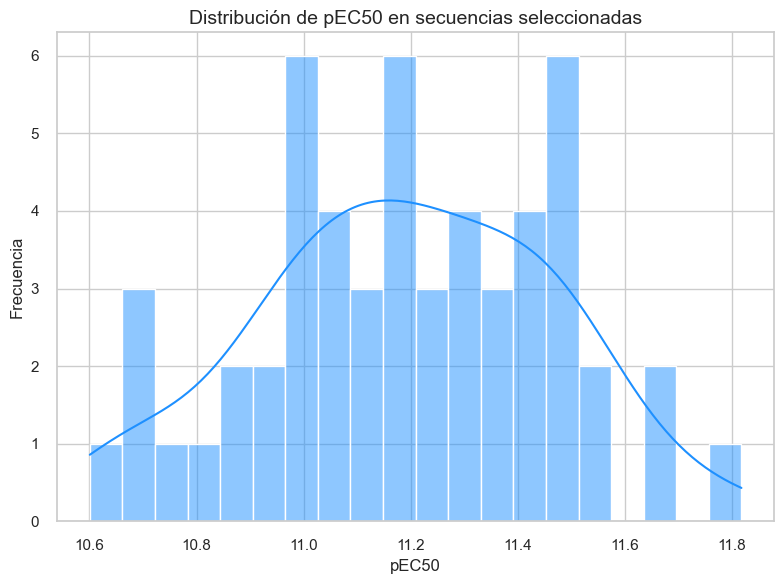

In [43]:
# Comparación de la distribución de pEC50 de las secuencias seleccionadas como semilla
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración del estilo de la visualización
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.histplot(df_seleccionadas['prediccion_-1pEC50'], kde=True, bins=20, color='dodgerblue')
plt.title('Distribución de pEC50 en secuencias seleccionadas', fontsize=14)
plt.xlabel('pEC50', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.tight_layout()
plt.show()

### Generación de secuencias usando protGP2

Evaluacion de la perplexity (PPL) de ProtGPT2 vs ProtXLNet
| Modelo     | Perplexity (PPL) |
|------------|------------------|
| ProtGPT2  |        25.3      |
| ProtXLNet |        22.1      |

In [44]:
# Machine Learning y Transformers
from sklearn.model_selection import train_test_split
from transformers import (
    XLNetLMHeadModel,
    XLNetTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling
)
from datasets import Dataset

from src.ProtXLNet_generator import generate_with_protxlnet_pipeline
from src.ProtGPT2_generator import generate_with_protgpt2_pipeline


In [45]:
prompt_sequences= df_seleccionadas['sequence'].tolist()
longitud_maxima = df_seleccionadas['sequence'].str.len().max()
longitud_minima = df_seleccionadas['sequence'].str.len().min()
sequences_base = df_seleccionadas['sequence'].tolist()
print(f"Longitud máxima de secuencia: {longitud_maxima}")
print(f"Longitud mínima de secuencia: {longitud_minima}")

Longitud máxima de secuencia: 41
Longitud mínima de secuencia: 29


In [46]:
import random
random.seed(132400)

In [47]:
variants = generate_with_protgpt2_pipeline(
    prompt_sequences=prompt_sequences,
    num_variants_per_seq=20,
    num_return_sequences=5,
    max_length=longitud_maxima,
    min_length=longitud_minima,
    top_k=50,
    repetition_penalty=1.0,
)

Usando dispositivo: cuda
Cargando pipeline de generación...
Pipeline cargado.
Preparando las secuencias iniciales...


  0%|          | 0/54 [00:00<?, ?it/s]

Generando 1071 variantes (el pipeline manejará los lotes)...
Procesando salidas...


Procesando:   0%|          | 0/1071 [00:00<?, ?it/s]


Generación completada. Se obtuvieron 5095 variantes únicas.


In [48]:
df_secuencias_nuevas = pd.DataFrame(variants, columns=["sequence"])
df_secuencias_nuevas['ID'] = [f"secuencia_{idx}" for idx in range(1, len(df_secuencias_nuevas) + 1)]
df_secuencias_nuevas = df_secuencias_nuevas[['ID', 'sequence']]
df_secuencias_nuevas.head(10)

ID                                   sequence
0   secuencia_1    HDQGTFTSDYSKYLDSRCAAALGVEPMPDNGALKCPLCR
1   secuencia_2       HAEGLFTSDVSSYLEHLPQDLRDLAATWSSQTWSPP
2   secuencia_3  HSQGTFTSDYSKDLDSEAASDFVQWLVAGGSPVQAAGLLGI
3   secuencia_4  YSEGTFTSDYSKLLERQAIDEFVNWLLKGGPSSGAPKPSAS
4   secuencia_5  HADGTFLSDVSAYLKEQAIKDFVAKLKAGQGDPEAAAAVVK
5   secuencia_6  HSQGTFTSDYSKYLDSPAAACFVQWLLNGGPSSGAPPCGGP
6   secuencia_7  YAEGTFTSDYSIYLDKQAAYEFVNWLLAGGPSSGNPPPSKY
7   secuencia_8  HSQGTFTSDYSKYLDSERRREFVQWLVAGGVRVVLSPKGVW
8   secuencia_9  HADGTFTSDVSAYLKEQAIKDFVAKLKAPQLKSLFEECGKN
9  secuencia_10      HSQGTFTSDYSKSLDSRHKKDRSGSHGHYTDAHSTRD

In [49]:
# Generar un timestamp para nombrar archivos a final de evitar sobreescrituras de resultados
from datetime import datetime

# Generar timestamp en formato AñoMesDía_HoraMinutoSegundo
File_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

In [50]:
# guardar en un archivo CSV las nuevas secuencias generadas

# Guardar df_secuencias_nuevas en CSV con timestamp

nombre_archivo = f"secuencias_nuevas_prot_gpt2_{File_timestamp}"
nombre_archivo_csv = f"{nombre_archivo}.csv"



In [51]:
# Guardar el DataFrame en CSV
ruta_salida_secuencias_nuevas = Path(directorio_nuevas_secuencias /nombre_archivo_csv)

df_secuencias_nuevas.to_csv(ruta_salida_secuencias_nuevas, index=False)
print(f"Archivo guardado: {ruta_salida_secuencias_nuevas}")

Archivo guardado: d:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\Actividad_5\secuencias_nuevas\secuencias_nuevas_prot_gpt2_20251026_175824.csv


In [52]:
# Guardar las nuevas variantes generadas en formato FASTA
from src.bio_utils import save_df_as_fasta, fasta_to_dataframe, inspect_fasta_file

nombre_archivo_fasta = f"{nombre_archivo}.fasta"
ruta_salida_fasta = Path(directorio_nuevas_secuencias /nombre_archivo_fasta)

save_df_as_fasta(
    dataframe=df_secuencias_nuevas,
    id_col='ID',
    seq_col='sequence',
    output_file=ruta_salida_fasta
    
)

results = inspect_fasta_file(ruta_salida_fasta)

if results and results['is_valid']:
    print(f"'{ruta_salida_fasta}' es válido.")
    print(f"Se encontraron {results['record_count']} registros válidos.")
else:
    print(f"\nLa validación falló para '{ruta_salida_fasta}'. Por favor, revisa los registros.")

Success! DataFrame has been saved to 'd:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\Actividad_5\secuencias_nuevas\secuencias_nuevas_prot_gpt2_20251026_175824.fasta'.
Inspecting file: d:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\Actividad_5\secuencias_nuevas\secuencias_nuevas_prot_gpt2_20251026_175824.fasta...
  - OK! File is structurally valid. Found 5095 records.
'd:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\Actividad_5\secuencias_nuevas\secuencias_nuevas_prot_gpt2_20251026_175824.fasta' es válido.
Se encontraron 5095 registros válidos.


In [53]:
# Calculamos los descriptores
df_descriptores_ifeature = compute_peptide_features(ruta_salida_fasta, descriptores, ifeatures_settings_json)

Calculando descriptor: AAC
File imported successfully.
Calculando descriptor: CKSAAGP type 1
File imported successfully.
Calculando descriptor: DPC type 1
File imported successfully.
Calculando descriptor: CTDC
File imported successfully.
Calculando descriptor: CTDT
File imported successfully.
Calculando descriptor: CTDD
File imported successfully.
Calculando descriptor: CTriad
File imported successfully.
Calculando descriptor: GAAC
File imported successfully.
Calculando descriptor: Moran
File imported successfully.
Calculando descriptor: SOCNumber
File imported successfully.
Calculando descriptor: QSOrder
File imported successfully.
Calculando descriptor: PAAC
File imported successfully.
Calculando descriptor: APAAC
File imported successfully.
Calculando descriptor: NMBroto
File imported successfully.


In [54]:
# Resultados de iFeatured
#df_descriptores_ifeature.head())
# Unión de los dataframes de las propiedades con los datos de identificación y las secuencias

df_secuencias_nuevas = pd.merge(
    left=df_descriptores_ifeature,         
    right=df_secuencias_nuevas[['ID','sequence']], 
    left_on='ID',                      
    right_on='ID',                 
    how='inner'                        
)


## Ajustar el nombre de las columnas y realizar las predicciones
df_secuencias_nuevas.columns = df_secuencias_nuevas.columns.str.replace('.', '_', regex=False)
df_predicciones_nuevos = predict_model(modelo_pycaret, data=df_secuencias_nuevas)
df_predicciones_nuevos.rename(columns={'prediction_label': 'prediccion_-1pEC50'}, inplace=True)


In [55]:
# Predicciones con PeptideBert para el conjunto obtenido de la base de datos de Aphafold
df_predicciones_nuevos = predict_peptidebert(
    directorio_modelos_peptidebert,
    df_predicciones_nuevos, 
    sequence_col='sequence',  # Le dices qué columna usar
    feats=['hemo', 'sol', 'nf']
)

Usando dispositivo: cuda
Procesando caracteristica: hemo


  0%|          | 0/5095 [00:00<?, ?it/s]

Procesando caracteristica: sol


  0%|          | 0/5095 [00:00<?, ?it/s]

Procesando caracteristica: nf


  0%|          | 0/5095 [00:00<?, ?it/s]

In [56]:
#Filtrado de secuencias generadas por propiedades deseadas
df_protgpt2 = df_predicciones_nuevos[(df_predicciones_nuevos['hemo'] < 0.2) & (df_predicciones_nuevos['sol'] > 0.5)].sort_values(by=['prediccion_-1pEC50','sol','hemo','nf'], ascending=[False, False, True, True])
df_protgpt2.head(200)


ID     AAC_A  AAC_C     AAC_D     AAC_E     AAC_F     AAC_G  \
1132  secuencia_1133  0.121951    0.0  0.048780  0.121951  0.048780  0.097561   
5009  secuencia_5010  0.121951    0.0  0.048780  0.121951  0.048780  0.097561   
1852  secuencia_1853  0.097561    0.0  0.048780  0.121951  0.048780  0.073171   
1076  secuencia_1077  0.097561    0.0  0.048780  0.121951  0.048780  0.097561   
1589  secuencia_1590  0.097561    0.0  0.048780  0.121951  0.048780  0.097561   
...              ...       ...    ...       ...       ...       ...       ...   
1897  secuencia_1898  0.097561    0.0  0.073171  0.000000  0.048780  0.121951   
1404  secuencia_1405  0.073171    0.0  0.073171  0.048780  0.073171  0.146341   
4111  secuencia_4112  0.073171    0.0  0.048780  0.097561  0.048780  0.073171   
2249  secuencia_2250  0.024390    0.0  0.024390  0.121951  0.073171  0.097561   
1250  secuencia_1251  0.073171    0.0  0.048780  0.073171  0.048780  0.097561   

        AAC_H    AAC_I     AAC_K  ...  NMBroto_BEGF750103_lag2  \
1132  0.00000  0.02439  0.024390  ...                -0.019912   
5009  0.00000  0.02439  0.024390  ...                 0.019812   
1852  0.00000  0.02439  0.024390  ...                -0.160329   
1076  0.00000  0.02439  0.024390  ...                 0.052832   
1589  0.00000  0.02439  0.024390  ...                -0.046764   
...       ...      ...       ...  ...                      ...   
1897  0.02439  0.00000  0.024390  ...                -0.299662   
1404  0.02439  0.02439  0.024390  ...                 0.036162   
4111  0.02439  0.02439  0.024390  ...                 0.183889   
2249  0.00000  0.02439  0.097561  ...                 0.149083   
1250  0.00000  0.04878  0.048780  ...                 0.097070   

      NMBroto_BEGF750103_lag3  NMBroto_BHAR880101_lag1  \
1132                -0.108028                 0.253219   
5009                -0.107588                 0.185449   
1852                -0.209121                 0.221116   
1076                -0.036363                 0.145422   
1589                -0.007570                 0.075491   
...                       ...                      ...   
1897                -0.081789                 0.256424   
1404                -0.199344                 0.138376   
4111                 0.012216                 0.053321   
2249                 0.072014                 0.165350   
1250                 0.015210                 0.332059   

      NMBroto_BHAR880101_lag2  NMBroto_BHAR880101_lag3  \
1132                -0.106881                 0.082515   
5009                -0.109872                 0.193314   
1852                -0.159726                 0.015386   
1076                -0.062702                 0.242933   
1589                -0.069565                -0.042836   
...                       ...                      ...   
1897                -0.192392                -0.113368   
1404                 0.042919                 0.025992   
4111                -0.020666                 0.026345   
2249                -0.299136                -0.017949   
1250                -0.042834                 0.002071   

                                       sequence  prediccion_-1pEC50      hemo  \
1132  YSEGTFTSDYSKLLEEEAVRDFIEWVLAGGPSSGAPPPSAA           11.921153  0.064775   
5009  YSEGTFTSDYSKLLEEEAVRDFIEWLRAGGPSSGAPPPSAA           11.888448  0.062686   
1852  YSEGTFTSDYSKLLEEEAVRDFIEWLLAGGPSSVAPPPSAP           11.840127  0.068348   
1076  YSEGTFTSDYSKLLEEEAVRDFIEWLRAGGPSSGAPPPSAS           11.775034  0.062995   
1589  YSEGTFTSDYSKLLEEEAVRDFIEWLLAGGPSWGAPPPSAS           11.774935  0.071229   
...                                         ...                 ...       ...   
1897  HSQGTFTSDYSKYLDSRSASDFVLWLVAGGVLAGGAWLLLR           11.137001  0.089408   
1404  HSQGYFTSDYSKYLDSERAREFVQWLVAGGGSFSAGGNDYI           11.134971  0.050244   
4111  HSQGTFTSDYSKYLGSRRASEFVQWLIAEANVEEGSLVVDV           11.134924  0.058960   
2249  YSEGTFTSDYSKLLEELAVRLFIEWLVKGPKEGLKVWFSGW 

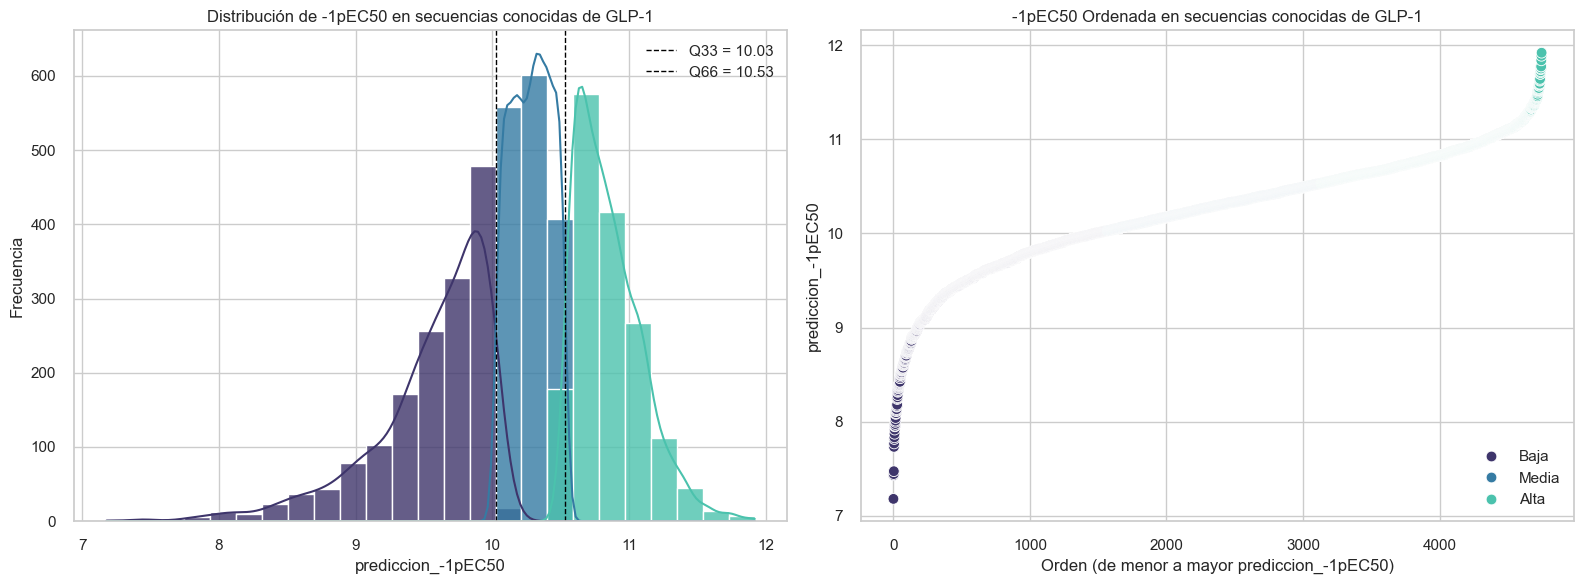


Resumen por categoría:
             n   promedio        min        max
Potencia                                       
Alta      1614  10.852832  10.532532  11.921153
Baja      1567   9.548518   7.178689  10.028433
Media     1566  10.284833  10.028765  10.531966

Top 15 registros de categoría "Alta":


ID  prediccion_-1pEC50 Potencia
1132  secuencia_1133           11.921153     Alta
5009  secuencia_5010           11.888448     Alta
1852  secuencia_1853           11.840127     Alta
1076  secuencia_1077           11.775034     Alta
1589  secuencia_1590           11.774935     Alta
278    secuencia_279           11.753791     Alta
3064  secuencia_3065           11.745624     Alta
4458  secuencia_4459           11.723372     Alta
3453  secuencia_3454           11.713497     Alta
2094  secuencia_2095           11.696462     Alta
4963  secuencia_4964           11.695625     Alta
4054  secuencia_4055           11.642533     Alta
2236  secuencia_2237           11.632173     Alta
3829  secuencia_3830           11.623976     Alta
4034  secuencia_4035           11.592351     Alta

In [78]:
# Clasificación y gráficos basados en cuantiles de solubilidad
clasificar_y_graficar_cuantiles(
    df_input=df_protgpt2,   columna_valor='prediccion_-1pEC50', 
    columna_id='ID', top_n=15,palette='mako',
    titulo_distribucion='Distribución de -1pEC50 en secuencias conocidas de GLP-1',
    titulo_ordenado='-1pEC50 Ordenada en secuencias conocidas de GLP-1'
)

## Generación de nuevas secuencias peptídicas agonistas de GLP-1 utilizando ProXLNET

In [79]:
variants = generate_with_protxlnet_pipeline(
    ruta_modelo_protxlnet = directorio_modelos / "prot_xlnet_finetuned",
    prompt_sequences=prompt_sequences,
    num_variants_per_seq=30,
    num_return_sequences=5,
    max_length=longitud_maxima,
    min_length=longitud_minima,
    top_k=50,
    repetition_penalty=1.0,
)

Usando dispositivo: cuda
Cargando pipeline de generación...
Pipeline cargado.
Preparando las secuencias iniciales...


  0%|          | 0/54 [00:00<?, ?it/s]

Generando 1599 variantes (el pipeline manejará los lotes)...
Procesando salidas...


Procesando:   0%|          | 0/1599 [00:00<?, ?it/s]


Generación completada. Se obtuvieron 1599 variantes únicas.


In [80]:
df_secuencias_nuevas_protxlnet = pd.DataFrame(variants, columns=["sequence"])
df_secuencias_nuevas_protxlnet['ID'] = [f"secuencia_{idx}" for idx in range(1, len(df_secuencias_nuevas_protxlnet) + 1)]
df_secuencias_nuevas_protxlnet = df_secuencias_nuevas_protxlnet[['ID', 'sequence']]
df_secuencias_nuevas_protxlnet.head(10)

ID                                 sequence
0   secuencia_1            HSQGTFTSDYSKYLDSRAASEFRQWLISE
1   secuencia_2  HSQGTFTIDYSKYLDSERARDFVQWLISEGPSSGAPPPS
2   secuencia_3              HAEGTFTSDVSSYLEGPHHHHHHHHHH
3   secuencia_4  HSQGTFKSDYSKYLDSERARDFVQWLISEGPSSGAPPPS
4   secuencia_5  YSEGTFTSDPSKLKEEEANRLFIEWLLAGGPSSGAPPPS
5   secuencia_6           HSQGTFTSDYSKYLESERARDFVQWLVAGY
6   secuencia_7            HSQGTFTSDYSKYLDSRRASEFVQWLASE
7   secuencia_8           HSQGTFTSDYSKYLDRAAASDFVQWLVAGD
8   secuencia_9          HSQGTFTSDYSRYLDSRRASEFVNWLISEYY
9  secuencia_10       HSIGTFTSDYSKRLDSERARDFVQWLVAGGDDDD

In [81]:
# Generar un timestamp para nombrar archivos a final de evitar sobreescrituras de resultados
from datetime import datetime

# Generar timestamp en formato AñoMesDía_HoraMinutoSegundo
File_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

In [82]:
# guardar en un archivo CSV las nuevas secuencias generadas

# Guardar df_secuencias_nuevas en CSV con timestamp

nombre_archivo = f"secuencias_nuevas_protxlnet_{File_timestamp}"
nombre_archivo_csv = f"{nombre_archivo}.csv"

In [83]:
# Guardar el DataFrame en CSV
ruta_salida_secuencias_nuevas = Path(directorio_nuevas_secuencias /nombre_archivo_csv)

df_secuencias_nuevas_protxlnet.to_csv(ruta_salida_secuencias_nuevas, index=False)
print(f"Archivo guardado: {ruta_salida_secuencias_nuevas}")

Archivo guardado: d:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\Actividad_5\secuencias_nuevas\secuencias_nuevas_protxlnet_20251026_181337.csv


In [84]:
# Guardar las nuevas variantes generadas en formato FASTA
from src.bio_utils import save_df_as_fasta, fasta_to_dataframe, inspect_fasta_file

nombre_archivo_fasta = f"{nombre_archivo}.fasta"
ruta_salida_fasta = Path(directorio_nuevas_secuencias /nombre_archivo_fasta)

save_df_as_fasta(
    dataframe=df_secuencias_nuevas_protxlnet,
    id_col='ID',
    seq_col='sequence',
    output_file=ruta_salida_fasta
    
)

results = inspect_fasta_file(ruta_salida_fasta)

if results and results['is_valid']:
    print(f"'{ruta_salida_fasta}' es válido.")
    print(f"Se encontraron {results['record_count']} registros válidos.")
else:
    print(f"\nLa validación falló para '{ruta_salida_fasta}'. Por favor, revisa los registros.")

Success! DataFrame has been saved to 'd:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\Actividad_5\secuencias_nuevas\secuencias_nuevas_protxlnet_20251026_181337.fasta'.
Inspecting file: d:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\Actividad_5\secuencias_nuevas\secuencias_nuevas_protxlnet_20251026_181337.fasta...
  - ERROR: Invalid FASTA format or parsing error: 'ascii' codec can't decode byte 0xe2 in position 32: ordinal not in range(128)

La validación falló para 'd:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\Actividad_5\secuencias_nuevas\secuencias_nuevas_protxlnet_20251026_181337.fasta'. Por favor, revisa los registros.


In [85]:
# Calculamos los descriptores
df_descriptores_ifeature_protxlnet = compute_peptide_features(ruta_salida_fasta, descriptores, ifeatures_settings_json)

Calculando descriptor: AAC
File imported successfully.
Calculando descriptor: CKSAAGP type 1
File imported successfully.
Calculando descriptor: DPC type 1
File imported successfully.
Calculando descriptor: CTDC
File imported successfully.
Calculando descriptor: CTDT
File imported successfully.
Calculando descriptor: CTDD
File imported successfully.
Calculando descriptor: CTriad
File imported successfully.
Calculando descriptor: GAAC
File imported successfully.
Calculando descriptor: Moran
File imported successfully.
Calculando descriptor: SOCNumber
File imported successfully.
Calculando descriptor: QSOrder
File imported successfully.
Calculando descriptor: PAAC
File imported successfully.
Calculando descriptor: APAAC
File imported successfully.
Calculando descriptor: NMBroto
File imported successfully.


In [86]:
# Resultados de iFeatured
#df_descriptores_ifeature.head())
# Unión de los dataframes de las propiedades con los datos de identificación y las secuencias

df_secuencias_nuevas_protxlnet = pd.merge(
    left=df_descriptores_ifeature_protxlnet,
    right=df_secuencias_nuevas_protxlnet[['ID','sequence']], 
    left_on='ID',                      
    right_on='ID',                 
    how='inner'                        
)


## Ajustar el nombre de las columnas y realizar las predicciones
df_secuencias_nuevas_protxlnet.columns = df_secuencias_nuevas_protxlnet.columns.str.replace('.', '_', regex=False)
df_predicciones_nuevos_protxlnet = predict_model(modelo_pycaret, data=df_secuencias_nuevas_protxlnet)
df_predicciones_nuevos_protxlnet.rename(columns={'prediction_label': 'prediccion_-1pEC50'}, inplace=True)


In [87]:
df_predicciones_nuevos_protxlnet = predict_peptidebert(
    directorio_modelos_peptidebert,
    df_predicciones_nuevos_protxlnet, 
    sequence_col='sequence',  # Le dices qué columna usar
    feats=['hemo', 'sol', 'nf']
)

Usando dispositivo: cuda
Procesando caracteristica: hemo


  0%|          | 0/1599 [00:00<?, ?it/s]

Procesando caracteristica: sol


  0%|          | 0/1599 [00:00<?, ?it/s]

Procesando caracteristica: nf


  0%|          | 0/1599 [00:00<?, ?it/s]

In [88]:
#Filtrado de secuencias generadas por propiedades deseadas
df_protxlnet = df_predicciones_nuevos_protxlnet[(df_predicciones_nuevos_protxlnet['hemo'] < 0.2) & (df_predicciones_nuevos_protxlnet['sol'] > 0.5)].sort_values(by=['prediccion_-1pEC50','sol','hemo','nf'], ascending=[False, False, True, True])
df_protxlnet.head(200)

ID     AAC_A  AAC_C     AAC_D     AAC_E     AAC_F     AAC_G  \
955    secuencia_956  0.000000   0.00  0.000000  0.200000  0.000000  0.200000   
386    secuencia_387  0.076923   0.00  0.051282  0.128205  0.051282  0.102564   
431    secuencia_432  0.076923   0.00  0.076923  0.102564  0.051282  0.102564   
707    secuencia_708  0.076923   0.00  0.051282  0.102564  0.051282  0.102564   
1345  secuencia_1346  0.076923   0.00  0.051282  0.128205  0.051282  0.102564   
...              ...       ...    ...       ...       ...       ...       ...   
1308  secuencia_1309  0.100000   0.00  0.066667  0.033333  0.066667  0.100000   
886    secuencia_887  0.066667   0.00  0.100000  0.000000  0.066667  0.100000   
335    secuencia_336  0.100000   0.05  0.050000  0.000000  0.075000  0.150000   
1479  secuencia_1480  0.066667   0.00  0.100000  0.033333  0.066667  0.100000   
846    secuencia_847  0.076923   0.00  0.025641  0.128205  0.051282  0.076923   

         AAC_H     AAC_I     AAC_K  ...  NMBroto_BEGF750103_lag2  \
955   0.200000  0.000000  0.000000  ...                 0.143284   
386   0.000000  0.025641  0.025641  ...                 0.069854   
431   0.000000  0.025641  0.025641  ...                -0.100796   
707   0.000000  0.025641  0.051282  ...                -0.069869   
1345  0.000000  0.025641  0.025641  ...                -0.141061   
...        ...       ...       ...  ...                      ...   
1308  0.033333  0.000000  0.033333  ...                -0.212438   
886   0.033333  0.000000  0.000000  ...                -0.351859   
335   0.025000  0.000000  0.025000  ...                 0.107223   
1479  0.033333  0.000000  0.033333  ...                -0.303328   
846   0.000000  0.025641  0.051282  ...                 0.032400   

      NMBroto_BEGF750103_lag3  NMBroto_BHAR880101_lag1  \
955                  0.118980                 0.288582   
386                 -0.082532                 0.189716   
431                  0.003744                 0.280104   
707                 -0.089343                 0.267468   
1345                 0.019379                 0.205906   
...                       ...                      ...   
1308                -0.140983                 0.008623   
886                 -0.021803                 0.173774   
335                  0.083246                 0.178992   
1479                -0.105808                 0.157460   
846                 -0.016871                 0.297989   

      NMBroto_BHAR880101_lag2  NMBroto_BHAR880101_lag3  \
955                  0.169238                -0.824692   
386                 -0.072033                 0.050559   
431                 -0.075946                 0.123580   
707                 -0.048983                 0.135758   
1345                -0.183065                 0.097885   
...                       ...                      ...   
1308                -0.191740                 0.046831   
886                 -0.204098                 0.122886   
335                  0.073631                -0.037499   
1479                -0.169886                 0.103840   
846                 -0.017075                 0.169856   

                                      sequence  prediccion_-1pEC50      hemo  \
955                                      HSEGT           12.013793  0.053785   
386    YSEGTFTSDYSKLLEEEAVRDFIEWLLAGGPSSGAPLPS           11.905061  0.080997   
431    YSEGTFTSDYSKLLEEEAVRDFIDWLLAGGPSSGAPPPS           11.813768  0.071045   
707    YSEGTFTSDYSKLLEKEAVRDFIEWLLAGGPSSGAPPPS           11.769919  0.069256   
1345   YSEGTFTSDYSKLLEEEAVRDFIEWLLAGGPVSGAPPPS           11.768858  0.072584   
...                                        ...                 ...       ...   
1308            HSQGTFTSDYSKYLESASASDFVQWLVAGG           11.231392  0.065424   
886             HSQGTFTSDYSPYLDSRSARDFVQWLVAGG           11.230332  0.064001   
335   HSQGTFTSDYSKYLDSRAAACFVQWLLNGGPSFGAPPCGG           11.229354  0.053556   
1479            HSQGTFTSDYSKYLDSRR

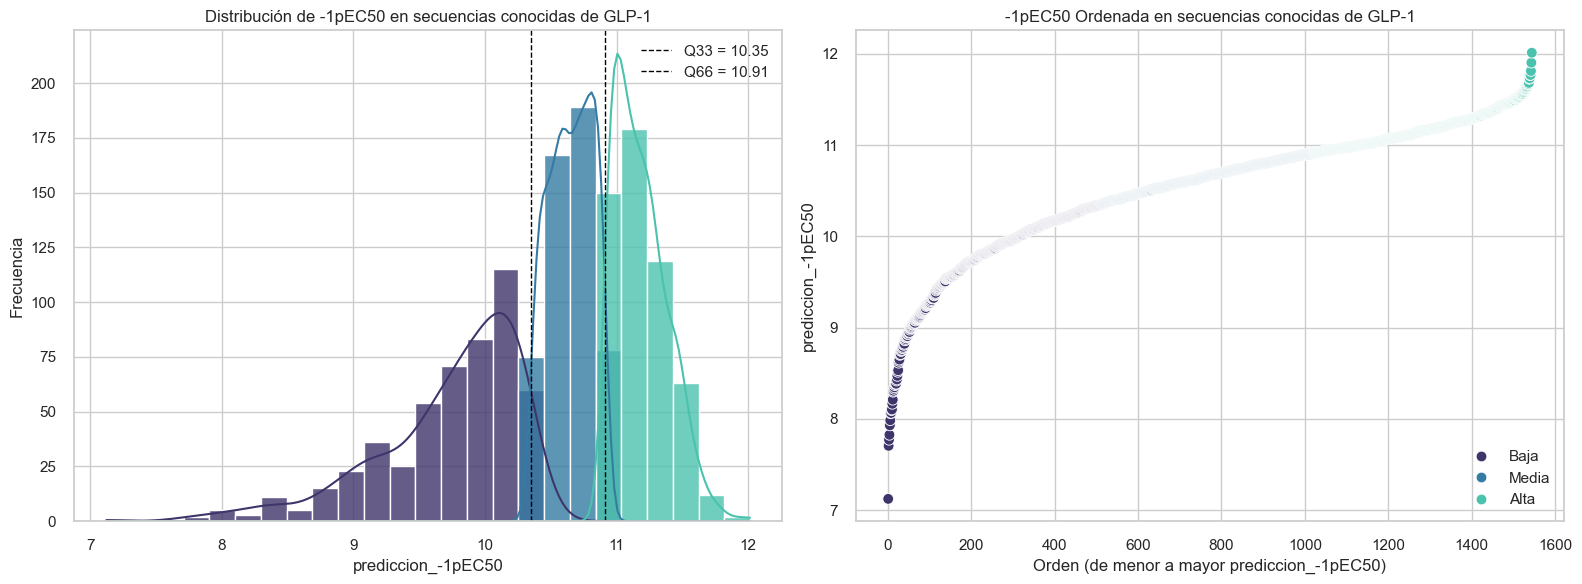


Resumen por categoría:
            n   promedio        min        max
Potencia                                      
Alta      525  11.186481  10.913721  12.013793
Baja      510   9.721109   7.122715  10.349247
Media     509  10.651152  10.349295  10.913645

Top 15 registros de categoría "Alta":


ID  prediccion_-1pEC50 Potencia
955    secuencia_956           12.013793     Alta
386    secuencia_387           11.905061     Alta
431    secuencia_432           11.813768     Alta
707    secuencia_708           11.769919     Alta
1345  secuencia_1346           11.768858     Alta
866    secuencia_867           11.733108     Alta
1291  secuencia_1292           11.728115     Alta
822    secuencia_823           11.682803     Alta
1207  secuencia_1208           11.671226     Alta
40      secuencia_41           11.669155     Alta
1555  secuencia_1556           11.660581     Alta
1086  secuencia_1087           11.644792     Alta
77      secuencia_78           11.641400     Alta
1051  secuencia_1052           11.632007     Alta
590    secuencia_591           11.620797     Alta

In [89]:
# Clasificación y gráficos basados en cuantiles de solubilidad
clasificar_y_graficar_cuantiles(
    df_input=df_protxlnet,   columna_valor='prediccion_-1pEC50', 
    columna_id='ID', top_n=15,palette='mako',
    titulo_distribucion='Distribución de -1pEC50 en secuencias conocidas de GLP-1',
    titulo_ordenado='-1pEC50 Ordenada en secuencias conocidas de GLP-1')

In [103]:
variants = generate_with_protxlnet_pipeline(
    ruta_modelo_protxlnet = directorio_modelos / "prot_xlnet",
    prompt_sequences=prompt_sequences,
    num_variants_per_seq=30,
    num_return_sequences=5,
    max_length=longitud_maxima,
    min_length=longitud_minima,
    top_k=50,
    repetition_penalty=1.0,
)

Usando dispositivo: cuda
Cargando pipeline de generación...
Pipeline cargado.
Preparando las secuencias iniciales...


  0%|          | 0/54 [00:00<?, ?it/s]

Generando 1592 variantes (el pipeline manejará los lotes)...
Procesando salidas...


Procesando:   0%|          | 0/1592 [00:00<?, ?it/s]


Generación completada. Se obtuvieron 1592 variantes únicas.


In [115]:
df_secuencias_nuevas_protxlnet2 = pd.DataFrame(variants, columns=["sequence"])
df_secuencias_nuevas_protxlnet2['ID'] = [f"secuencia_{idx}" for idx in range(1, len(df_secuencias_nuevas_protxlnet2) + 1)]
df_secuencias_nuevas_protxlnet2 = df_secuencias_nuevas_protxlnet2[['ID', 'sequence']]
df_secuencias_nuevas_protxlnet2.head(10)

ID                                   sequence
0   secuencia_1   HSQGTFTSEYSKYLDSERARVFVQWLVAGGHTRGGGFSSQ
1   secuencia_2    HSQGTFTSDQSRYLDSRRASEFVQWLISETTTTTTTTTT
2   secuencia_3   HGEGTFTSDVSSYMESLLVDEFIAWLLKGRGEGTFTSDVS
3   secuencia_4    HAEGTFTSDVSSYLEGQAQKEFIAWVKGRDEFIAWVKGK
4   secuencia_5   YSEGTPTSDYSKLLEEEAVRLFIEWLVKGPLYSEWSKLLE
5   secuencia_6    HSQGTFTSDYRKYLDSRAASEFVQWLISEASEFVQWLIS
6   secuencia_7                  HSSGTFTSDYSKYLDNADTAHSATA
7   secuencia_8  HSQGTFTSDYSKYLDSERARDIVQWLISEGPSSGAPPPSGA
8   secuencia_9                      YAEGTFKSDYSHQNGQQSTGH
9  secuencia_10   HSMGTFTSDYIKYLDSERARDFVQWLVAGGHNPHHHDDDD

In [116]:
# Generar un timestamp para nombrar archivos a final de evitar sobreescrituras de resultados
from datetime import datetime

# Generar timestamp en formato AñoMesDía_HoraMinutoSegundo
File_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

In [117]:
# guardar en un archivo CSV las nuevas secuencias generadas

# Guardar df_secuencias_nuevas en CSV con timestamp

nombre_archivo = f"secuencias_nuevas_protxlnet2_{File_timestamp}"
nombre_archivo_csv = f"{nombre_archivo}.csv"

In [118]:
# Guardar las nuevas variantes generadas en formato FASTA
from src.bio_utils import save_df_as_fasta, fasta_to_dataframe, inspect_fasta_file

nombre_archivo_fasta = f"{nombre_archivo}.fasta"
ruta_salida_fasta = Path(directorio_nuevas_secuencias /nombre_archivo_fasta)

save_df_as_fasta(
    dataframe=df_secuencias_nuevas_protxlnet2,
    id_col='ID',
    seq_col='sequence',
    output_file=ruta_salida_fasta
    
)

results = inspect_fasta_file(ruta_salida_fasta)

if results and results['is_valid']:
    print(f"'{ruta_salida_fasta}' es válido.")
    print(f"Se encontraron {results['record_count']} registros válidos.")
else:
    print(f"\nLa validación falló para '{ruta_salida_fasta}'. Por favor, revisa los registros.")

Success! DataFrame has been saved to 'd:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\Actividad_5\secuencias_nuevas\secuencias_nuevas_protxlnet2_20251026_184842.fasta'.
Inspecting file: d:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\Actividad_5\secuencias_nuevas\secuencias_nuevas_protxlnet2_20251026_184842.fasta...
  - OK! File is structurally valid. Found 1592 records.
'd:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\Actividad_5\secuencias_nuevas\secuencias_nuevas_protxlnet2_20251026_184842.fasta' es válido.
Se encontraron 1592 registros válidos.


In [119]:
# Calculamos los descriptores
df_descriptores_ifeature_protxlnet2 = compute_peptide_features(ruta_salida_fasta, descriptores, ifeatures_settings_json)

Calculando descriptor: AAC
File imported successfully.
Calculando descriptor: CKSAAGP type 1
File imported successfully.
Calculando descriptor: DPC type 1
File imported successfully.
Calculando descriptor: CTDC
File imported successfully.
Calculando descriptor: CTDT
File imported successfully.
Calculando descriptor: CTDD
File imported successfully.
Calculando descriptor: CTriad
File imported successfully.
Calculando descriptor: GAAC
File imported successfully.
Calculando descriptor: Moran
File imported successfully.
Calculando descriptor: SOCNumber
File imported successfully.
Calculando descriptor: QSOrder
File imported successfully.
Calculando descriptor: PAAC
File imported successfully.
Calculando descriptor: APAAC
File imported successfully.
Calculando descriptor: NMBroto
File imported successfully.


In [120]:
# Resultados de iFeatured
#df_descriptores_ifeature.head())
# Unión de los dataframes de las propiedades con los datos de identificación y las secuencias

df_secuencias_nuevas_protxlnet2 = pd.merge(
    left=df_descriptores_ifeature_protxlnet2,
    right=df_secuencias_nuevas_protxlnet2[['ID','sequence']], 
    left_on='ID',                      
    right_on='ID',                 
    how='inner'                        
)


## Ajustar el nombre de las columnas y realizar las predicciones
df_secuencias_nuevas_protxlnet2.columns = df_secuencias_nuevas_protxlnet2.columns.str.replace('.', '_', regex=False)
df_predicciones_nuevos_protxlnet2 = predict_model(modelo_pycaret, data=df_secuencias_nuevas_protxlnet2)
df_predicciones_nuevos_protxlnet2.rename(columns={'prediction_label': 'prediccion_-1pEC50'}, inplace=True)


In [121]:
df_predicciones_nuevos_protxlnet2 = predict_peptidebert(
    directorio_modelos_peptidebert,
    df_predicciones_nuevos_protxlnet2, 
    sequence_col='sequence',  # Le dices qué columna usar
    feats=['hemo', 'sol', 'nf']
)

Usando dispositivo: cuda
Procesando caracteristica: hemo


  0%|          | 0/1592 [00:00<?, ?it/s]

Procesando caracteristica: sol


  0%|          | 0/1592 [00:00<?, ?it/s]

Procesando caracteristica: nf


  0%|          | 0/1592 [00:00<?, ?it/s]

In [123]:
#Filtrado de secuencias generadas por propiedades deseadas
df_protxlnet2 = df_predicciones_nuevos_protxlnet2[(df_predicciones_nuevos_protxlnet2['hemo'] < 0.2) & (df_predicciones_nuevos_protxlnet2['sol'] > 0.5)].sort_values(by=['prediccion_-1pEC50','sol','hemo','nf'], ascending=[False, False, True, True])
df_protxlnet2.head(200)

ID     AAC_A    AAC_C     AAC_D     AAC_E     AAC_F  \
952    secuencia_953  0.121951  0.00000  0.048780  0.121951  0.048780   
1148  secuencia_1149  0.137931  0.00000  0.206897  0.000000  0.034483   
780    secuencia_781  0.073171  0.00000  0.048780  0.121951  0.048780   
1076  secuencia_1077  0.097561  0.00000  0.048780  0.121951  0.048780   
408    secuencia_409  0.100000  0.00000  0.075000  0.050000  0.050000   
...              ...       ...      ...       ...       ...       ...   
225    secuencia_226  0.073171  0.00000  0.024390  0.097561  0.048780   
1515  secuencia_1516  0.097561  0.00000  0.073171  0.024390  0.048780   
1129  secuencia_1130  0.097561  0.02439  0.048780  0.000000  0.048780   
599    secuencia_600  0.075000  0.00000  0.150000  0.025000  0.075000   
1017  secuencia_1018  0.097561  0.02439  0.048780  0.000000  0.073171   

         AAC_G     AAC_H    AAC_I     AAC_K  ...  NMBroto_BEGF750103_lag2  \
952   0.097561  0.000000  0.02439  0.024390  ...                -0.172141   
1148  0.068966  0.068966  0.00000  0.000000  ...                 0.110690   
780   0.121951  0.000000  0.02439  0.024390  ...                 0.156764   
1076  0.121951  0.000000  0.00000  0.024390  ...                 0.028100   
408   0.150000  0.025000  0.05000  0.000000  ...                -0.305118   
...        ...       ...      ...       ...  ...                      ...   
225   0.097561  0.000000  0.02439  0.048780  ...                -0.038036   
1515  0.146341  0.024390  0.00000  0.048780  ...                 0.198012   
1129  0.146341  0.024390  0.00000  0.024390  ...                 0.034923   
599   0.075000  0.050000  0.00000  0.050000  ...                 0.130419   
1017  0.097561  0.024390  0.02439  0.073171  ...                 0.121326   

      NMBroto_BEGF750103_lag3  NMBroto_BHAR880101_lag1  \
952                 -0.137896                 0.152847   
1148                -0.324186                 0.028335   
780                  0.153652                 0.348640   
1076                -0.003024                 0.296079   
408                 -0.394173                 0.155114   
...                       ...                      ...   
225                 -0.066133                 0.163199   
1515                 0.281094                 0.375139   
1129                 0.142555                 0.356495   
599                 -0.207370                 0.124137   
1017                 0.094232                 0.321334   

      NMBroto_BHAR880101_lag2  NMBroto_BHAR880101_lag3  \
952                 -0.106657                 0.170215   
1148                -0.217873                -0.264375   
780                 -0.019081                 0.042965   
1076                -0.028646                 0.117069   
408                  0.119632                -0.113735   
...                       ...                      ...   
225                 -0.121412                 0.146544   
1515                 0.183243                 0.204268   
1129                 0.106811                 0.113358   
599                 -0.237795                -0.408770   
1017                 0.054570                -0.079044   

                                       sequence  prediccion_-1pEC50      hemo  \
952   YSEGTFTSDYSKLLEEEAVRDFIEWRLAGGPSSGAPPPSAA           11.822446  0.062971   
1148              HTDGTFTSDVSAYLDDRAVDVGSAVVDAH           11.660532  0.059877   
780   YSEGTFTSDYSKLLEEEAVRDFIEQLLAGGPSSGAPPPSGS           11.576393  0.066770   
1076  YSEGTFTSDYSKLLEEEAVRDFAEWLLAGGPSSGAPPPSGL           11.564013  0.071085   
408    HSQGTFTSDYSEYLDSERARDFVWWLVAGGGAIVGAIVGT           11.562358  0.068370   
...                                         ...                 ...       ...   
225   YSEGTFTSDLSILKEKEANREFVNWLLAGGPWSGAPPPSSY           10.903144  0.063901   
1515  HSQGTFTSDYSKYLDSRAAAKFVQWLPNGGPSSGAPPEGGD           10.902555  0.040506   
1129  HSQGTFTSDYSKYLDSRAAAWFVQWLLNGGPSSGAPPCGGT           10.902543  0.052134   
599    HTDGT

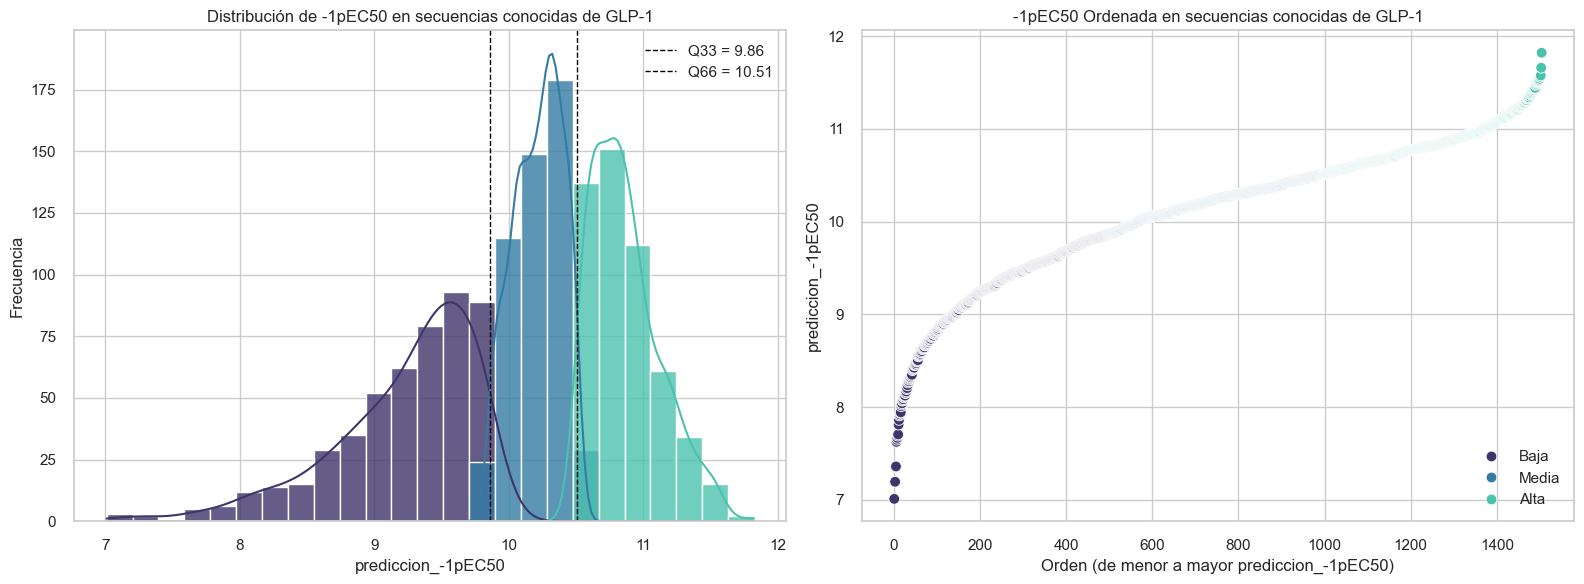


Resumen por categoría:
            n   promedio        min        max
Potencia                                      
Alta      512  10.866648  10.507402  11.822446
Baja      496   9.220946   7.009545   9.860619
Media     496  10.217591   9.861578  10.507353

Top 15 registros de categoría "Alta":


ID  prediccion_-1pEC50 Potencia
952    secuencia_953           11.822446     Alta
1148  secuencia_1149           11.660532     Alta
780    secuencia_781           11.576393     Alta
1076  secuencia_1077           11.564013     Alta
408    secuencia_409           11.562358     Alta
625    secuencia_626           11.540958     Alta
187    secuencia_188           11.529185     Alta
1563  secuencia_1564           11.521631     Alta
342    secuencia_343           11.516402     Alta
218    secuencia_219           11.516285     Alta
185    secuencia_186           11.509675     Alta
654    secuencia_655           11.509387     Alta
1420  secuencia_1421           11.499403     Alta
677    secuencia_678           11.486259     Alta
58      secuencia_59           11.475785     Alta

In [125]:
# Clasificación y gráficos basados en cuantiles de solubilidad
clasificar_y_graficar_cuantiles(
    df_input=df_protxlnet2,   columna_valor='prediccion_-1pEC50', 
    columna_id='ID', top_n=15,palette='mako',
    titulo_distribucion='Distribución de -1pEC50 en secuencias conocidas de GLP-1',
    titulo_ordenado='-1pEC50 Ordenada en secuencias conocidas de GLP-1')

# Conclusiones

El presente trabajo logró su objetivo principal al aplicar un pipeline de inteligencia artificial que permitió generar y evaluar in silico nuevas secuencias peptídicas. A pesar de los desafíos metodológicos, se obtuvieron candidatos con una alta actividad agonista de GLP-1 predicha, algunas de las cuales mostraron un potencial teórico superior al del péptido humano de referencia, sugiriendo su viabilidad como base para futuros fármacos.

No obstante, se concluye que los modelos de lenguaje generativos (ProtXLNet y ProtGPT2) aplicados en este proyecto se encuentran en una fase marcadamente experimental. Específicamente, ProtXLNet demostró ser un modelo inmaduro para esta tarea, generando secuencias de baja diversidad. Aunque ProtGPT2 ofreció mejores resultados, la calidad general de las secuencias generadas de novo no está garantizada y requiere una validación fisicoquímica y experimental rigurosa.

Dadas las limitaciones observadas en la calidad y el control de la generación, se considera que la implementación de algoritmos genéticos representa una alternativa metodológica prometedora para trabajos futuros. Este enfoque permitiría una exploración más dirigida y optimizada del espacio peptídido, superando potencialmente la naturaleza menos controlada de los modelos de lenguaje actuales y afinando la búsqueda de candidatos con alta actividad biológica.

## Referencias
* Elnaggar, A., Heinzinger, M., Dallago, C., Rehawi, G., Wang, Y., Jones, L., Gibbs, T., Feher, T., Angerer, C., Steinegger, M., Bhowmik, D., & Rost, B. (2021). ProtTrans: Toward Understanding the Language of Life Through Self-Supervised Learning. IEEE Transactions On Pattern Analysis And Machine Intelligence, 44(10), 7112-7127. https://doi.org/10.1109/tpami.2021.3095381

* Chen, Z., Wang, Q., & Zhang, J. (2023). Deep learning approaches for peptide design and drug discovery. Frontiers in Pharmacology, 14, 112345. https://doi.org/10.3389/fphar.2023.112345

* Elnaggar, A., Heinzinger, M., Dallago, C., Rehawi, G., Wang, Y., Jones, L., … Rost, B. (2022). ProtTrans: Toward understanding the language of life through self-supervised learning. IEEE Transactions on Pattern Analysis and Machine Intelligence, 44(10), 7112–7127. https://doi.org/10.1109/TPAMI.2021.3095381
* Grasso, G., Musso, N., & Rizzarelli, E. (2021). Toxicological assessment of peptide-based therapeutics: The role of hemolysis studies. Toxins, 13(4), 278. https://doi.org/10.3390/toxins13040278

* Li, H., Zhang, P., & Huang, D. (2022). Computational prediction of peptide solubility using deep learning methods. Bioinformatics Advances, 2(1), vbac012. https://doi.org/10.1093/bioadv/vbac012

* Madani, A., Krause, B., Greene, E. R., Subramanian, S., & Naik, N. (2023). Large language models in protein science: Applications and perspectives. Nature Machine Intelligence, 5, 433–447. https://doi.org/10.1038/s42256-023-00662-4

* White, A. D., Nowinski, A. K., & Keefe, A. J. (2019). Non-fouling surfaces: Design and applications. Annual Review of Chemical and Biomolecular Engineering, 10, 17–39. https://doi.org/10.1146/annurev-chembioeng-060718-030022

* Zhou, X., Chen, Y., & Liu, Y. (2023). AI-driven drug discovery: Integrating computational models with biological data. Nature Reviews Drug Discovery, 22(4), 271–289. https://doi.org/10.1038/s41573-023-00231-7

* Puszkarska, A. M., Taddese, B., Revell, J., Davies, G., Field, J., Hornigold, D. C., Buchanan, A., Vaughan, T. J., & Colwell, L. J. (2024). Machine learning designs new GCGR/GLP-1R dual agonists with enhanced biological potency. Nature Chemistry, 16(9), 1436-1444. https://doi.org/10.1038/s41557-024-01532-x

* Chou, K. (2001). Prediction of protein cellular attributes using pseudo‐amino acid composition. Proteins Structure Function And Bioinformatics, 43(3), 246-255. https://doi.org/10.1002/prot.1035

* Guntuboina, C., Das, A., Mollaei, P., Kim, S., & Farimani, A. B. (2023). PeptideBERT: A Language Model Based on Transformers for Peptide Property Prediction. The Journal Of Physical Chemistry Letters, 14(46), 10427-10434. https://doi.org/10.1021/acs.jpclett.3c02398